In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_selection import f_regression
from sklearn.linear_model import LinearRegression


%matplotlib inline 

In [3]:
ames = pd.read_csv('./Ames_Housing_Price_Data.csv')
ames = ames.iloc[:,1:]

FileNotFoundError: [Errno 2] File b'./Ames_Housing_Price_Data.csv' does not exist: b'./Ames_Housing_Price_Data.csv'

## Feature type check

In [3]:
ames.columns = ames.columns.str.lower()
ames.mssubclass = ames.mssubclass.astype('object')
ames.mosold = ames.mosold.astype('object')

By readling the data dictionaory, a few features come in ordinary scale, such as 'OverallQual' and 'OverallCond'. To decide whether or not to convert these data type, we check the scatter plot of saleprice against these features, to see if there is a linear pattern.

In [4]:
oridinal_col = ['overallqual','overallcond','exterqual','extercond','bsmtqual','bsmtcond','bsmtfintype1',\
                'bsmtfintype2','kitchenqual','fireplacequ','poolqc','garagecond','garagequal']

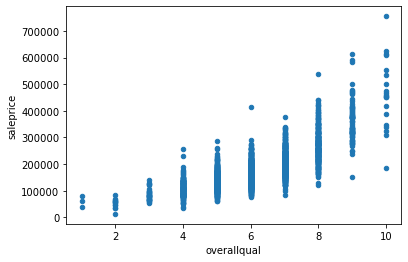

In [5]:
ames[['overallqual','saleprice']].plot(x='overallqual',y='saleprice',kind='scatter')

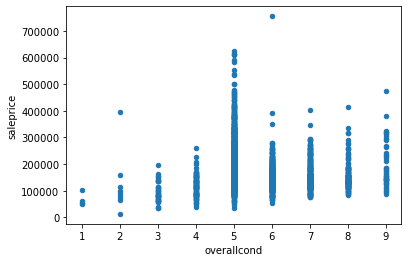

In [6]:
ames[['overallcond','saleprice']].plot(x='overallcond',y='saleprice',kind='scatter')

'overallqual' and 'overallcond' show nearly linear pattern, therefore these 2 columns will be treated as numeric values in the data set. All others will be treated as categorial features.

## Missing Data Cleanning

Missingness: it seems that all the missing come from a non-existing feature, therefore I fill in all the numeric features with 0 and categorical features with ‘No [feature]’ or similar pattern. 

### Remarks:

*mansvnrtype / masvnrarea: missing because the house is solid brick? In that case, the price might be different.

*garage: row 433, 531 have garage type but with many missing values in garage specs

*‘Electrical’ : 1 missing data

*When 'Garagetype' is ‘no garage’, the value of 'garageyrblt', 'garagefinish', 'garagecars', 'garagearea', 'garagequal', 'garagecond' will have multicollinearity since they will all be coded 0 or ‘No Garage’. For ML purposes, the overall model will include ‘garagetype’ or 'garagearea' only, if significant, the data set will be split in with/without garage for further analysis.

*The same with the basement features group.

In [7]:
ames.loc[ames.lotfrontage.isnull(),'lotfrontage'] = 0
ames.loc[ames.alley.isnull(),'alley'] = 'No Alley'
ames.loc[ames.masvnrtype.isnull(),'masvnrtype'] = 'Missing'
ames.loc[ames.masvnrarea.isnull(),'masvnrarea'] = 0
ames.loc[ames.bsmtqual.isnull(),'bsmtqual'] = 'No Bsmt'
ames.loc[ames.bsmtcond.isnull(),'bsmtcond'] = 'No Bsmt'
ames.loc[ames.bsmtexposure.isnull(),'bsmtexposure'] = 'No Bsmt'
ames.loc[ames.bsmtfintype1.isnull(),'bsmtfintype1'] = 'No Bsmt'
ames.loc[ames.bsmtfinsf1.isnull(),'bsmtfinsf1'] = 0
ames.loc[ames.bsmtfintype2.isnull(),'bsmtfintype2'] = 'No Bsmt'
ames.loc[ames.bsmtfinsf2.isnull(),'bsmtfinsf2'] = 0
ames.loc[ames.bsmtunfsf.isnull(),'bsmtunfsf'] = 0
ames.loc[ames.totalbsmtsf.isnull(),'totalbsmtsf'] = 0
ames.loc[ames.bsmtfullbath.isnull(),'bsmtfullbath'] = 0
ames.loc[ames.bsmthalfbath.isnull(),'bsmthalfbath'] = 0
ames.loc[ames.fireplaces == 0,'fireplacequ'] = 'No Fireplace'
ames.loc[ames.garagetype.isnull(),'garagetype'] = 'No Garage'
ames.loc[ames.garagetype == 'No Garage','garageyrblt'] = 0
ames.loc[ames.garagetype == 'No Garage','garagefinish'] = 'No Garage'
ames.loc[ames.garagetype == 'No Garage','garagecars'] = 0
ames.loc[ames.garagetype == 'No Garage','garagearea'] = 0
ames.loc[ames.garagetype == 'No Garage','garagequal'] = 'No Garage'
ames.loc[ames.garagetype == 'No Garage','garagecond'] = 'No Garage'
ames.loc[ames.poolarea == 0,'poolqc'] = 'No Pool'
ames.loc[ames.fence.isnull(),'fence'] = 'No Fence'
ames.loc[ames.miscfeature.isnull(),'miscfeature'] = 'None'

In [8]:
ames.loc[ames.garageyrblt.isnull(),]

,pid,grlivarea,saleprice,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,lotconfig,landslope,neighborhood,condition1,condition2,bldgtype,housestyle,overallqual,overallcond,yearbuilt,yearremodadd,roofstyle,roofmatl,exterior1st,exterior2nd,masvnrtype,masvnrarea,exterqual,extercond,foundation,bsmtqual,bsmtcond,bsmtexposure,bsmtfintype1,bsmtfinsf1,bsmtfintype2,bsmtfinsf2,bsmtunfsf,totalbsmtsf,heating,heatingqc,centralair,electrical,1stflrsf,2ndflrsf,lowqualfinsf,bsmtfullbath,bsmthalfbath,fullbath,halfbath,bedroomabvgr,kitchenabvgr,kitchenqual,totrmsabvgrd,functional,fireplaces,fireplacequ,garagetype,garageyrblt,garagefinish,garagecars,garagearea,garagequal,garagecond,paveddrive,wooddecksf,openporchsf,enclosedporch,3ssnporch,screenporch,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition
433,910201180,1828,150909,70,RM,50.0,9060,Pave,No Alley,Reg,Lvl,AllPub,Inside,Gtl,IDOTRR,Norm,Norm,1Fam,2Story,5,6,1923,1999,Gable,CompShg,Wd Sdng,Plywood,None,0.0,TA,TA,BrkTil,Gd,TA,No,ALQ,548.0,Unf,0.0,311.0,859.0,GasA,Ex,Y,SBrkr,942,886,0,0.0,0.0,2,0,3,1,Gd,6,Typ,0,No Fireplace,Detchd,NaN,NaN,NaN,NaN,NaN,NaN,Y,174,0,212,0,0,0,No Pool,MnPrv,None,0,3,2007,WD,Alloca
531,903426160,1984,160000,60,RM,57.0,8094,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Norm,Norm,2fmCon,2.5Unf,6,8,1910,1983,Gable,CompShg,Wd Sdng,Wd Sdng,None,0.0,TA,TA,PConc,TA,TA,Mn,Rec,196.0,Unf,0.0,1046.0,1242.0,GasA,Gd,Y,SBrkr,1242,742,0,0.0,0.0,2,0,5,1,TA,8,Typ,0,No Fireplace,Detchd,NaN,NaN,1.0,360.0,NaN,NaN,Y,64,0,180,0,0,0,No Pool,MnPrv,Shed,1000,9,2008,WD,Normal


In [9]:
ames.loc[ames.electrical.isnull(),]

,pid,grlivarea,saleprice,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,lotconfig,landslope,neighborhood,condition1,condition2,bldgtype,housestyle,overallqual,overallcond,yearbuilt,yearremodadd,roofstyle,roofmatl,exterior1st,exterior2nd,masvnrtype,masvnrarea,exterqual,extercond,foundation,bsmtqual,bsmtcond,bsmtexposure,bsmtfintype1,bsmtfinsf1,bsmtfintype2,bsmtfinsf2,bsmtunfsf,totalbsmtsf,heating,heatingqc,centralair,electrical,1stflrsf,2ndflrsf,lowqualfinsf,bsmtfullbath,bsmthalfbath,fullbath,halfbath,bedroomabvgr,kitchenabvgr,kitchenqual,totrmsabvgrd,functional,fireplaces,fireplacequ,garagetype,garageyrblt,garagefinish,garagecars,garagearea,garagequal,garagecond,paveddrive,wooddecksf,openporchsf,enclosedporch,3ssnporch,screenporch,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition
2442,916386080,1394,167500,80,RL,73.0,9735,Pave,No Alley,Reg,Lvl,AllPub,Inside,Gtl,Timber,Norm,Norm,1Fam,SLvl,5,5,2006,2007,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,Unf,0.0,Unf,0.0,384.0,384.0,GasA,Gd,Y,NaN,754,640,0,0.0,0.0,2,1,3,1,Gd,7,Typ,0,No Fireplace,BuiltIn,2007.0,Fin,2.0,400.0,TA,TA,Y,100,0,0,0,0,0,No Pool,No Fence,None,0,5,2008,WD,Normal


After the major data cleaning, 3 rows are still left with missing values. After checking the 3 records, the missing information cannot be imputed easily with existing information, so we decide to remove these 3 rows. 2577 rows of data will be included in the analysis.

In [10]:
ames2 = ames.dropna(axis=0).copy()
ames2.shape

(2577, 81)

## Adding Features

- 'price_sqft' = 'saleprice' / 'grlivarea'
 
- 'house_age'  = 'yrsold' - 'yearbuilt'
 
- 'reno_age' = 'yrsold' - 'yearremodadd'
 
- bathroom # above ground: 'tbath_abvgr' = 'fullbath' + 'halfbath'*0.5

- bathroom # in basement: 'tbath_bsmt' = 'bsmtfullbath' + 'bsmthalfbath'*0.5
 
- bedroom/bathroom ratio (above ground): 'bbratio_abvgr' = 'bedroomabvgr' / 'tbath_abvgr'
  
There are two houses only have bathroom in basement, so the 'bbratio_abvgr' will be uncalculatble. 

To make sense of the date, impute the missing data with 10.

### Be aware of multicollinearity between the introduced variables

In [11]:
ames2['price_sqft'] = ames2['saleprice'] / ames2['grlivarea']
ames2['house_age'] = ames2['yrsold'] - ames2['yearbuilt']
ames2['reno_age'] = ames2['yrsold'] - ames2['yearremodadd']
ames2.loc[ames2['reno_age']<0,'reno_age'] = 0
ames2['bbratio_abvgr'] = ames2['bedroomabvgr']/(ames2['fullbath'] + ames2['halfbath']*0.5 +\
                                                ames2['bsmtfullbath'] + ames2['bsmthalfbath']*0.5)
ames2.loc[ames2['bbratio_abvgr'].isnull(),'bbratio_abvgr'] = 10
ames2.loc[ames2['bbratio_abvgr']>10,'bbratio_abvgr'] = 10
ames2['tporch'] = ames2['wooddecksf']+ames2['openporchsf']+ames2['enclosedporch']\
                           +ames2['3ssnporch']+ames2['screenporch']

## Check Outliers

outliers: price higher or lower than 3 std

In [12]:
ames2[['saleprice','price_sqft']].describe()

,saleprice,price_sqft
count,2577.000000,2577.000000
mean,178081.264649,120.934759
std,75071.726566,30.637014
min,12789.000000,15.371394
25%,129900.000000,100.401606
50%,159900.000000,119.658120
75%,210000.000000,138.888889
max,755000.000000,276.250881


In [13]:
price_outliers = ames2[((ames2['saleprice'] - ames2['saleprice'].mean())/ames2['saleprice'].std() > 3) | \
     ((ames2['saleprice'] - ames2['saleprice'].mean())/ames2['saleprice'].std() < -3)]
outliersp = price_outliers.pid.tolist()
len(price_outliers)

42

In [14]:
price_outliers['saleprice'].mean()

479349.2380952381

The outliers in terms of saleprice are all high price houses. We will remove these houses to maintain the assumptions of regression model.

In [15]:
ames3 = ames2[~ames2['pid'].isin(price_outliers['pid'])]

(array([  4.,  19.,  92., 198., 481., 529., 367., 251., 196., 140.,  86.,
         55.,  50.,  29.,  25.,  15.,  13.,   7.,   8.,   2.,   0.,   3.,
          0.,   2.,   4.,   0.,   0.,   0.,   0.,   1.]),
 array([ 12789.        ,  37529.36666667,  62269.73333333,  87010.1       ,
        111750.46666667, 136490.83333333, 161231.2       , 185971.56666667,
        210711.93333333, 235452.3       , 260192.66666667, 284933.03333333,
        309673.4       , 334413.76666667, 359154.13333333, 383894.5       ,
        408634.86666667, 433375.23333333, 458115.6       , 482855.96666667,
        507596.33333333, 532336.7       , 557077.06666667, 581817.43333333,
        606557.8       , 631298.16666667, 656038.53333333, 680778.9       ,
        705519.26666667, 730259.63333333, 755000.        ]),
 <a list of 30 Patch objects>)

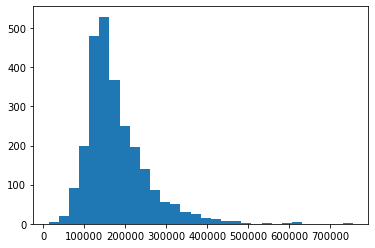

In [16]:
plt.hist(ames2['saleprice'], bins=30)

(array([  1.,   3.,   5.,  23.,  21.,  84.,  85., 158., 261., 308., 270.,
        204., 203., 177., 119., 113.,  86.,  80.,  63.,  56.,  49.,  27.,
         26.,  30.,  25.,  16.,   8.,  12.,  13.,   9.]),
 array([ 12789.        ,  25796.03333333,  38803.06666667,  51810.1       ,
         64817.13333333,  77824.16666667,  90831.2       , 103838.23333333,
        116845.26666667, 129852.3       , 142859.33333333, 155866.36666667,
        168873.4       , 181880.43333333, 194887.46666667, 207894.5       ,
        220901.53333333, 233908.56666667, 246915.6       , 259922.63333333,
        272929.66666667, 285936.7       , 298943.73333333, 311950.76666667,
        324957.8       , 337964.83333333, 350971.86666667, 363978.9       ,
        376985.93333333, 389992.96666667, 403000.        ]),
 <a list of 30 Patch objects>)

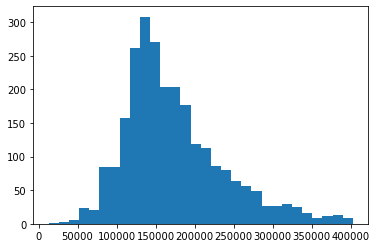

In [17]:
plt.hist(ames3['saleprice'], bins=30)

In [18]:
ames3.shape

(2535, 86)

The distribution of target variable is less skewed after removing the outliers, however a log transformation may still be desired for a more reliable model.

## Removing Abnormal Sale

By inspecting the data dictionary, there is one salecondition called 'Abnormal sale' that we want to exclude from our modeling. Abnormal Sale refers to those trade, foreclosure, and short sale. These sales may follow a different pricing pattern, which may lessen the descriptive power of our model. Therefore we want to exclude them.

In [19]:
ames3.groupby('salecondition')[['saleprice']].mean().reset_index()

,salecondition,saleprice
0,Abnorml,138218.750000
1,AdjLand,138750.000000
2,Alloca,158719.000000
3,Family,146958.823529
4,Normal,171669.506090
5,Partial,256841.319444


By looking at the average sale price of such salecondition, it is actually lower than all other type. 

In [20]:
ames3 =  ames3[ames3['salecondition'] != 'Abnorml']
ames3.shape

(2475, 86)

## Preparing data set

### Categorical Variables

Creating a list of all categorial variable for future uses.

Check the Boxplots for all categorical variable against price per sqft

In [21]:
factor_col = []
for col in ames3.columns:
    if ames3[col].dtype == 'O':
        factor_col.append(col)

AxesSubplot(0.1,0.15;0.8x0.75)
AxesSubplot(0.1,0.15;0.8x0.75)
AxesSubplot(0.1,0.15;0.8x0.75)
AxesSubplot(0.1,0.15;0.8x0.75)
AxesSubplot(0.1,0.15;0.8x0.75)
AxesSubplot(0.1,0.15;0.8x0.75)
AxesSubplot(0.1,0.15;0.8x0.75)
AxesSubplot(0.1,0.15;0.8x0.75)
AxesSubplot(0.1,0.15;0.8x0.75)
AxesSubplot(0.1,0.15;0.8x0.75)
AxesSubplot(0.1,0.15;0.8x0.75)
AxesSubplot(0.1,0.15;0.8x0.75)
AxesSubplot(0.1,0.15;0.8x0.75)
AxesSubplot(0.1,0.15;0.8x0.75)
AxesSubplot(0.1,0.15;0.8x0.75)
AxesSubplot(0.1,0.15;0.8x0.75)
AxesSubplot(0.1,0.15;0.8x0.75)
AxesSubplot(0.1,0.15;0.8x0.75)
AxesSubplot(0.1,0.15;0.8x0.75)
AxesSubplot(0.1,0.15;0.8x0.75)
AxesSubplot(0.1,0.15;0.8x0.75)
AxesSubplot(0.1,0.15;0.8x0.75)


C:\Users\Chun\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\tools.py:184: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(**fig_kw)
C:\Users\Chun\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\tools.py:184: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(**fig_kw)
C:\Users\Chun\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\tools.py:184: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until expl

AxesSubplot(0.1,0.15;0.8x0.75)
AxesSubplot(0.1,0.15;0.8x0.75)
AxesSubplot(0.1,0.15;0.8x0.75)
AxesSubplot(0.1,0.15;0.8x0.75)
AxesSubplot(0.1,0.15;0.8x0.75)
AxesSubplot(0.1,0.15;0.8x0.75)


C:\Users\Chun\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\tools.py:184: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(**fig_kw)
C:\Users\Chun\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\tools.py:184: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(**fig_kw)
C:\Users\Chun\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\tools.py:184: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until expl

AxesSubplot(0.1,0.15;0.8x0.75)
AxesSubplot(0.1,0.15;0.8x0.75)
AxesSubplot(0.1,0.15;0.8x0.75)
AxesSubplot(0.1,0.15;0.8x0.75)
AxesSubplot(0.1,0.15;0.8x0.75)
AxesSubplot(0.1,0.15;0.8x0.75)
AxesSubplot(0.1,0.15;0.8x0.75)


C:\Users\Chun\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\tools.py:184: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(**fig_kw)
C:\Users\Chun\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\tools.py:184: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(**fig_kw)
C:\Users\Chun\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\tools.py:184: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until expl

AxesSubplot(0.1,0.15;0.8x0.75)
AxesSubplot(0.1,0.15;0.8x0.75)
AxesSubplot(0.1,0.15;0.8x0.75)
AxesSubplot(0.1,0.15;0.8x0.75)
AxesSubplot(0.1,0.15;0.8x0.75)


C:\Users\Chun\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\tools.py:184: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(**fig_kw)
C:\Users\Chun\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\tools.py:184: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(**fig_kw)
C:\Users\Chun\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\tools.py:184: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until expl

AxesSubplot(0.1,0.15;0.8x0.75)
AxesSubplot(0.1,0.15;0.8x0.75)
AxesSubplot(0.1,0.15;0.8x0.75)
AxesSubplot(0.1,0.15;0.8x0.75)
AxesSubplot(0.1,0.15;0.8x0.75)


C:\Users\Chun\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\tools.py:184: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(**fig_kw)
C:\Users\Chun\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\tools.py:184: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(**fig_kw)
C:\Users\Chun\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\tools.py:184: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until expl

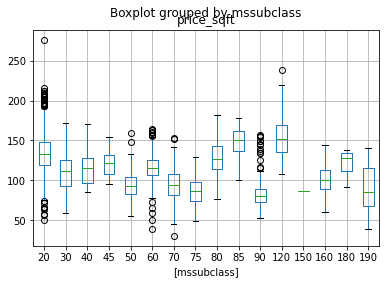

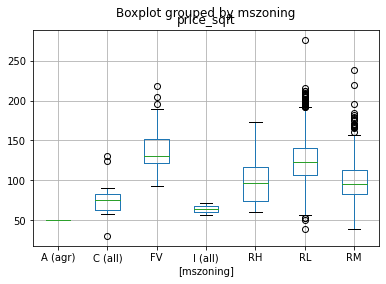

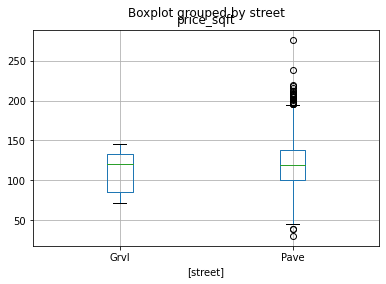

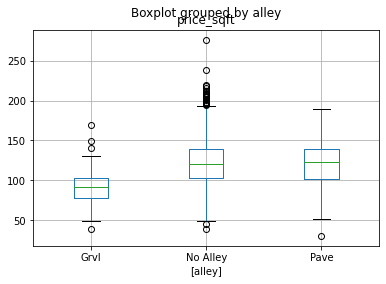

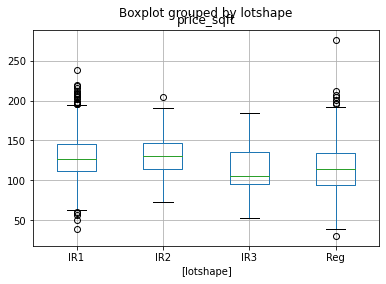

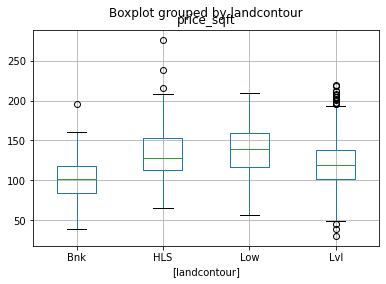

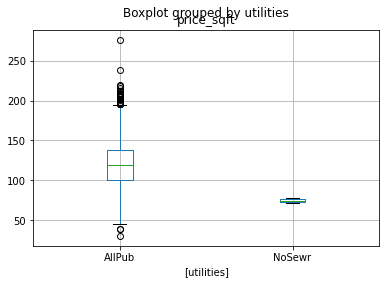

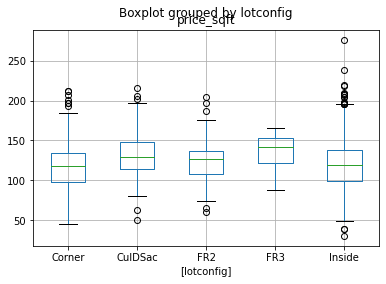

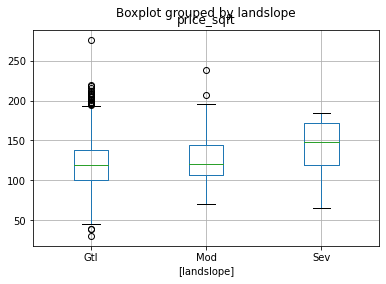

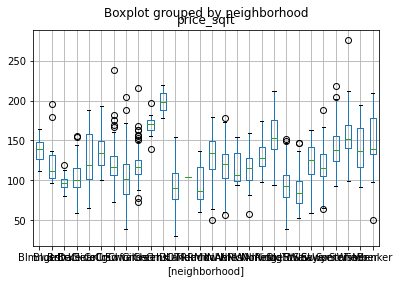

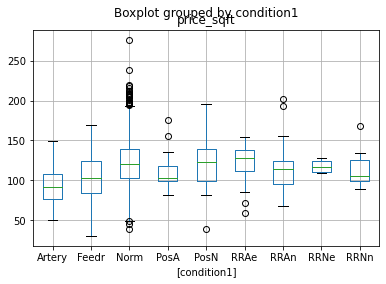

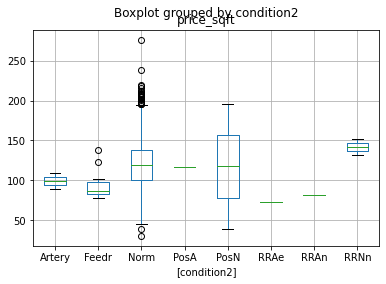

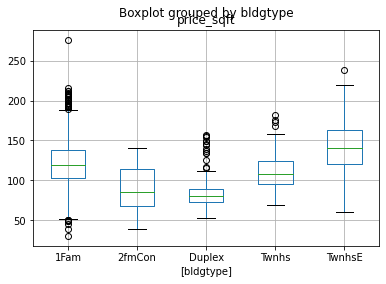

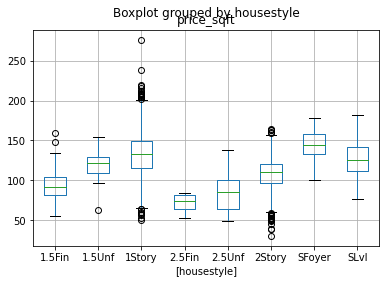

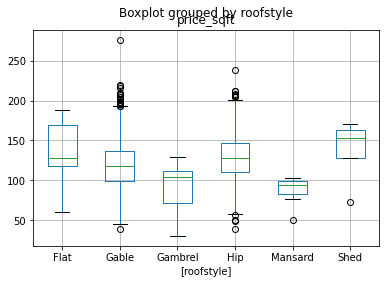

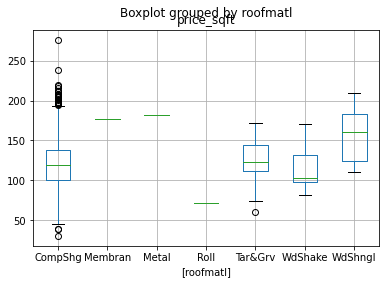

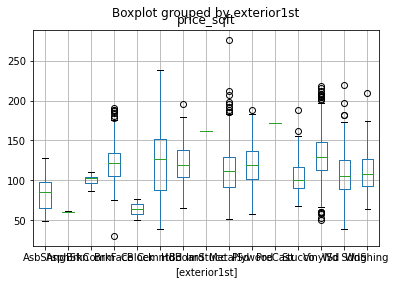

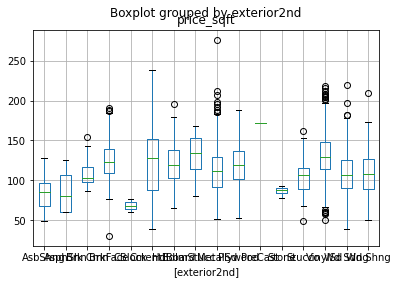

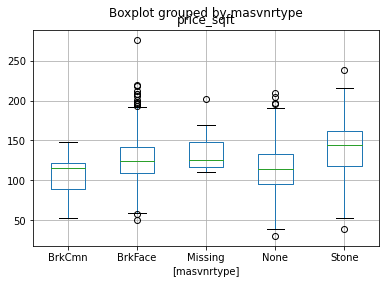

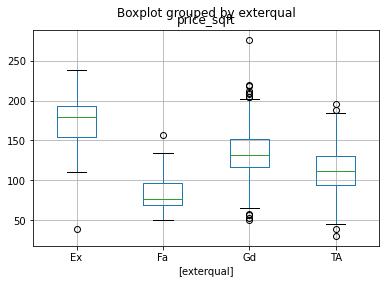

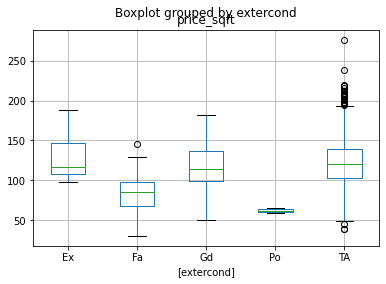

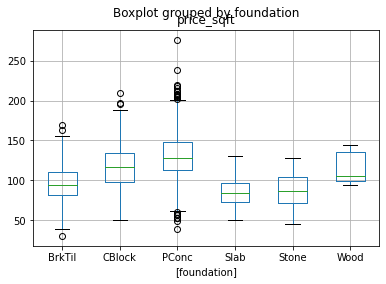

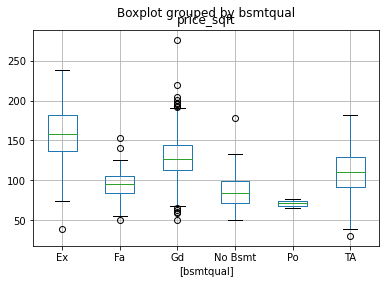

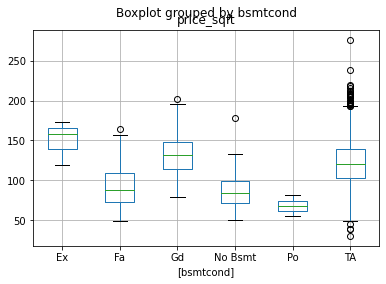

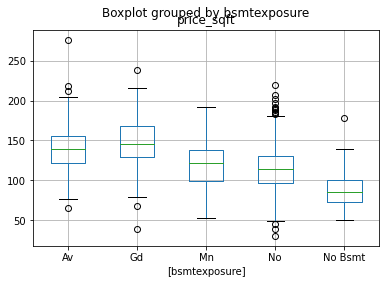

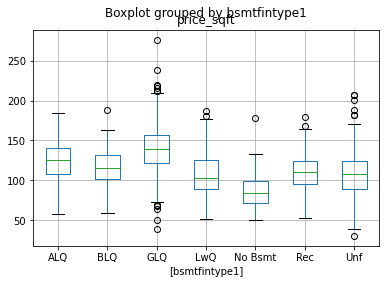

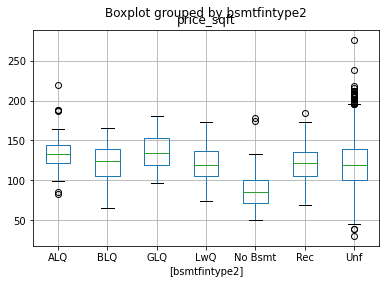

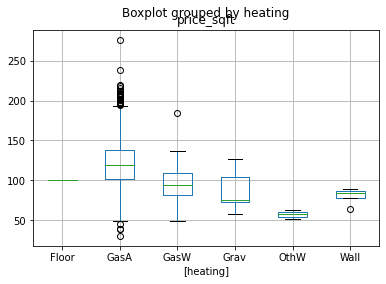

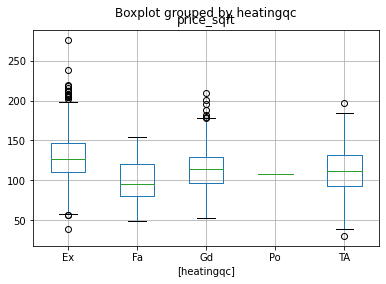

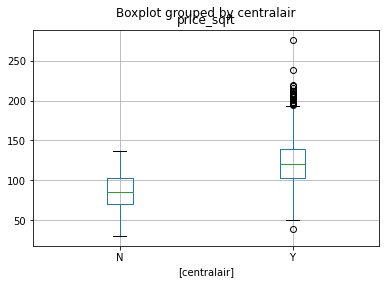

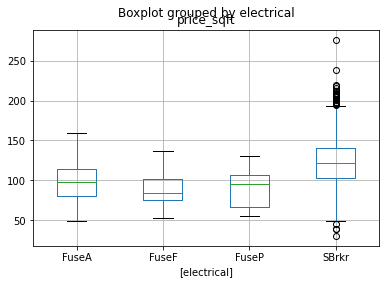

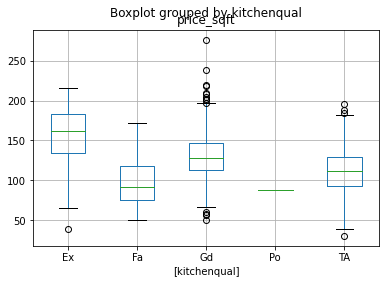

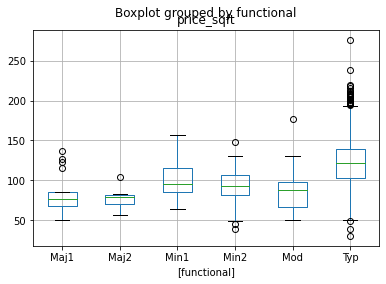

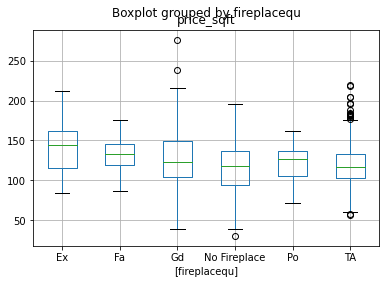

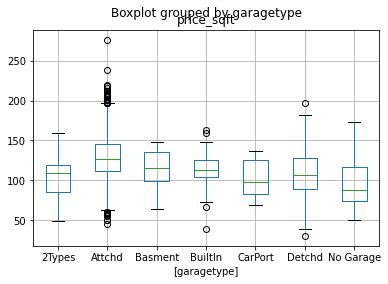

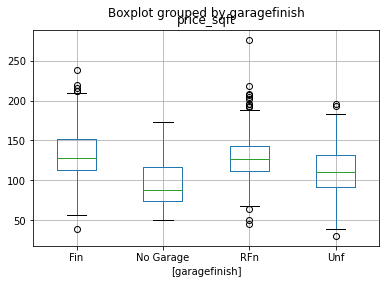

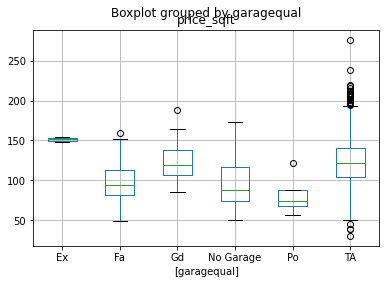

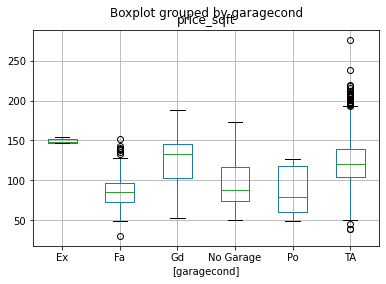

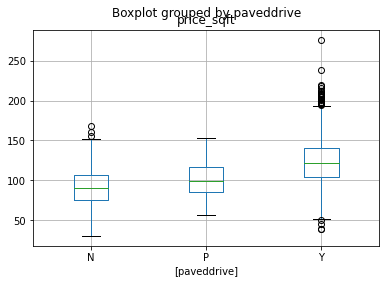

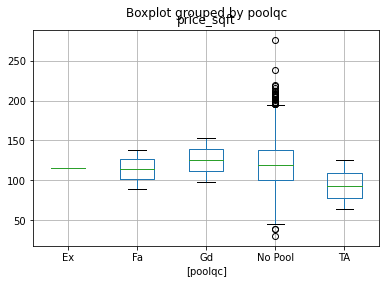

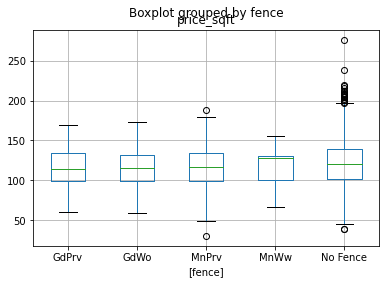

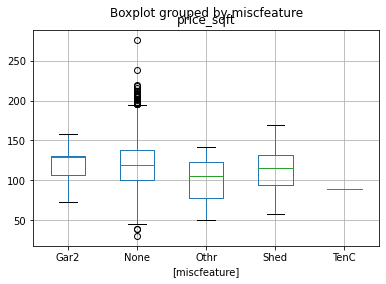

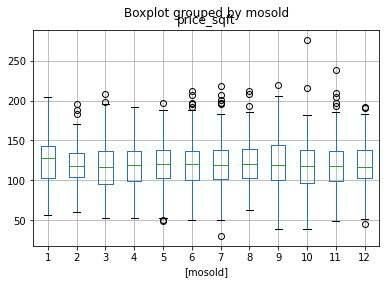

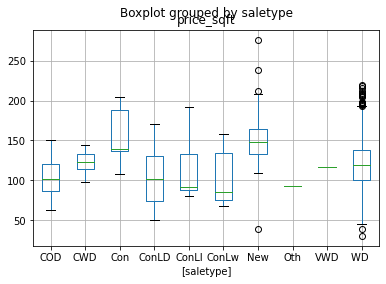

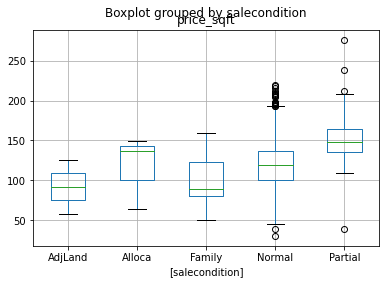

In [22]:
for col in factor_col:
    print(ames3[['price_sqft',col]].boxplot(by = col))

In [23]:
for col in factor_col:
    print(ames3[col].value_counts())

20     892
60     480
50     250
120    168
160    117
30     117
70     112
80     105
90      83
190     50
85      43
75      19
45      17
180     15
40       6
150      1
Name: mssubclass, dtype: int64
RL         1929
RM          399
FV          111
RH           20
C (all)      13
I (all)       2
A (agr)       1
Name: mszoning, dtype: int64
Pave    2465
Grvl      10
Name: street, dtype: int64
No Alley    2315
Grvl          99
Pave          61
Name: alley, dtype: int64
Reg    1578
IR1     820
IR2      64
IR3      13
Name: lotshape, dtype: int64
Lvl    2246
Bnk      92
HLS      86
Low      51
Name: landcontour, dtype: int64
AllPub    2473
NoSewr       2
Name: utilities, dtype: int64
Inside     1816
Corner      418
CulDSac     153
FR2          76
FR3          12
Name: lotconfig, dtype: int64
Gtl    2358
Mod     105
Sev      12
Name: landslope, dtype: int64
NAmes      398
CollgCr    233
OldTown    204
Edwards    160
Gilbert    142
Somerst    138
Sawyer     135
NWAmes     120
SawyerW  

By looking at the boxplots, it seems 'street', 'lotshape', 'loconfig', 'landslope', 'heatingqc', and 'fence' don't have strong influence on the price/sqft. May consider eliminating these features in the next steps.

Another observation is that many of the features have unbalanced values. This should be taken into consideration if any features are to be included in the model.

### Categorical variables

1. Convert oridinal type of features to int
2. Condense norminal categorical features to decrease the dimensions after dummification

In [24]:
ames3['heatingqc'] = ames3['heatingqc'].replace('Ex',5)
ames3['heatingqc'] = ames3['heatingqc'].replace('Gd',4)
ames3['heatingqc'] = ames3['heatingqc'].replace('TA',3)
ames3['heatingqc'] = ames3['heatingqc'].replace('Fa',2)
ames3['heatingqc'] = ames3['heatingqc'].replace('Po',1)
ames3['extercond'] = ames3['extercond'].replace('Ex',5)
ames3['extercond'] = ames3['extercond'].replace('Gd',4)
ames3['extercond'] = ames3['extercond'].replace('TA',3)
ames3['extercond'] = ames3['extercond'].replace('Fa',2)
ames3['extercond'] = ames3['extercond'].replace('Po',1)
ames3['exterqual'] = ames3['exterqual'].replace('Ex',5)
ames3['exterqual'] = ames3['exterqual'].replace('Gd',4)
ames3['exterqual'] = ames3['exterqual'].replace('TA',3)
ames3['exterqual'] = ames3['exterqual'].replace('Fa',2)
ames3['exterqual'] = ames3['exterqual'].replace('Po',1)
ames3['kitchenqual'] = ames3['kitchenqual'].replace('Ex',5)
ames3['kitchenqual'] = ames3['kitchenqual'].replace('Gd',4)
ames3['kitchenqual'] = ames3['kitchenqual'].replace('TA',3)
ames3['kitchenqual'] = ames3['kitchenqual'].replace('Fa',2)
ames3['kitchenqual'] = ames3['kitchenqual'].replace('Po',1)

In [25]:
ames3['mszoning'] = ames3['mszoning'].replace(['A (agr)','C (all)','I (all)','RH','FV'], 'others')
ames3['alley'] = ames3['alley'].replace(['Grvl','Pave'], 'others')
ames3['lotshape'] = ames3['lotshape'].replace(['IR1','IR2','IR3'], 'IR')
ames3['landcontour'] = ames3['landcontour'].replace(['HLS','Bnk','Low'], 'others')
ames3['condition1'] = ames3['condition1'].replace(['Feedr','Artery','RRAn','PosN','RRAe',\
                                                  'PosA','RRNn','RRNe'], 'others')
ames3['condition2'] = ames3['condition2'].replace(['Feedr','Artery','RRAn','PosN','RRAe',\
                                                  'PosA','RRNn','RRNe'], 'others')
ames3['housestyle'] = ames3['housestyle'].replace(['2.5Unf','1.5Unf','2.5Fin'], 'others')
ames3['roofstyle'] = ames3['roofstyle'].replace(['Hip','Gambrel','Flat','Mansard','Shed'], 'others')
ames3['roofmatl'] = ames3['roofmatl'].replace(['Tar&Grv','WdShake','WdShngl','Membran','Roll','Metal'], 'others')
ames3['salecondition'] = ames3['salecondition'].replace(['Family','Alloca','AdjLand'], 'others')
ames3['saletype'] = ames3['saletype'].replace(['ConLw','ConLI','Con','Oth','VWD','CWD','ConLD'], 'others')
ames3['mosold'] = ames3['mosold'].replace([1,2,3], 'QT1')
ames3['mosold'] = ames3['mosold'].replace([4,5,6], 'QT2')
ames3['mosold'] = ames3['mosold'].replace([7,8,9], 'QT3')
ames3['mosold'] = ames3['mosold'].replace([10,11,12], 'QT4')
ames3['miscfeature'] = ames3['miscfeature'].replace(['Shed','Gar2','Othr','TenC'], 'Yes')
ames3['garagecond'] = ames3['garagecond'].replace(['Gd','Ex'], 'Abv_Avg')
ames3['garagecond'] = ames3['garagecond'].replace(['Fa','Po'], 'Blw_Avg')
ames3['garagequal'] = ames3['garagequal'].replace(['Gd','Ex'], 'Abv_Avg')
ames3['garagequal'] = ames3['garagequal'].replace(['Fa','Po'], 'Blw_Avg')
ames3['fireplacequ'] = ames3['fireplacequ'].replace(['Gd','Ex'], 'Abv_Avg')
ames3['fireplacequ'] = ames3['fireplacequ'].replace(['Fa','Po'], 'Blw_Avg')
ames3['functional'] = ames3['functional'].replace(['Min1','Min2'], 'Min')
ames3['functional'] = ames3['functional'].replace(['Mod','Maj1','Maj2','Sev','Sal'], 'Mod_more')
ames3['electrical'] = ames3['electrical'].replace(['FuseA','FuseF','FuseP','Mix'],'Fuse')
ames3['bsmtcond'] = ames3['bsmtcond'].replace(['Gd','Ex'], 'Abv_Avg')
ames3['bsmtcond'] = ames3['bsmtcond'].replace(['Fa','Po'], 'Blw_Avg')
ames3['bsmtqual'] = ames3['bsmtqual'].replace(['Gd','Ex'], 'Abv_Avg')
ames3['bsmtqual'] = ames3['bsmtqual'].replace(['Fa','Po'], 'Blw_Avg')
ames3['exterior1st'] = ames3['exterior1st'].replace(['BrkComm','AsphShn','CBlock','PreCast','ImStucc','AsbShng'],'Others')
ames3['foundation'] = ames3['foundation'].replace(['Slab','Stone','Wood'],'Others')
ames3['heating'] = ames3['heating'].replace(['GasW','Grav','Wall','OthW','Floor'],'Others')
ames3['garagetype'] = ames3['garagetype'].replace(['Basment','2Types','CarPort'],'Others')

### Neighborhood Analysis

Based on our separate analysis on neighborhood, we will use two different way to regroup the neighborhood feature, to see if it will improve the performance of our model.

### 1. Based on Lon-Lat coordinates

In [26]:
neighbor = pd.read_csv('./data/df_nbhd_grp1.csv')
nbgroup = neighbor[['PID','nbhd_ne','nbhd_se','nbhd_sw','nbhd_east','nbhd_west']]
merged = pd.merge(ames3,nbgroup, left_on = 'pid', right_on = 'PID', how='inner')
merged = merged[~merged.duplicated()].drop('PID',axis=1)
merged['neighborhood'] = merged[['nbhd_ne','nbhd_se','nbhd_sw','nbhd_east','nbhd_west']].idxmax(axis=1)
merged = merged.drop(['nbhd_ne','nbhd_se','nbhd_sw','nbhd_east','nbhd_west'],axis=1)

### 2. Based on distant to major employer in Ames

In [205]:
neighbor2 = pd.read_csv('./data/df_nbhd_distgrp.csv')
nbgroup2 = neighbor2[['pid','nbhd_above_uoi','nbhd_below_uoi','nbhd_above_dot','nbhd_below_dot']]
merged2 = pd.merge(ames3,nbgroup2, on = 'pid',how='inner')
merged2 = merged2[~merged2.duplicated()]
merged2.drop(columns='neighborhood',inplace=True)

In [277]:
len(merged.columns.tolist())

86

## *Data Analysis Data Set*

In [27]:
merged.head()

,pid,grlivarea,saleprice,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,lotconfig,landslope,neighborhood,condition1,condition2,bldgtype,housestyle,overallqual,overallcond,yearbuilt,yearremodadd,roofstyle,roofmatl,exterior1st,exterior2nd,masvnrtype,masvnrarea,exterqual,extercond,foundation,bsmtqual,bsmtcond,bsmtexposure,bsmtfintype1,bsmtfinsf1,bsmtfintype2,bsmtfinsf2,bsmtunfsf,totalbsmtsf,heating,heatingqc,centralair,electrical,1stflrsf,2ndflrsf,lowqualfinsf,bsmtfullbath,bsmthalfbath,fullbath,halfbath,bedroomabvgr,kitchenabvgr,kitchenqual,totrmsabvgrd,functional,fireplaces,fireplacequ,garagetype,garageyrblt,garagefinish,garagecars,garagearea,garagequal,garagecond,paveddrive,wooddecksf,openporchsf,enclosedporch,3ssnporch,screenporch,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,price_sqft,house_age,reno_age,bbratio_abvgr,tporch
0,909176150,856,126000,30,RL,0.0,7890,Pave,No Alley,Reg,Lvl,AllPub,Corner,Gtl,nbhd_west,Norm,Norm,1Fam,1Story,6,6,1939,1950,Gable,CompShg,Wd Sdng,Wd Sdng,None,0.0,3,3,CBlock,TA,TA,No,Rec,238.0,Unf,0.0,618.0,856.0,GasA,3,Y,SBrkr,856,0,0,1.0,0.0,1,0,2,1,3,4,Typ,1,Abv_Avg,Detchd,1939.0,Unf,2.0,399.0,TA,TA,Y,0,0,0,0,166,0,No Pool,No Fence,None,0,QT1,2010,WD,Normal,147.196262,71,60,1.000000,166
1,905476230,1049,139500,120,RL,42.0,4235,Pave,No Alley,Reg,Lvl,AllPub,Inside,Gtl,nbhd_west,Norm,Norm,TwnhsE,1Story,5,5,1984,1984,Gable,CompShg,HdBoard,HdBoard,BrkFace,149.0,4,3,CBlock,Abv_Avg,TA,Mn,GLQ,552.0,ALQ,393.0,104.0,1049.0,GasA,3,Y,SBrkr,1049,0,0,1.0,0.0,2,0,2,1,4,5,Typ,0,No Fireplace,Attchd,1984.0,Fin,1.0,266.0,TA,TA,Y,0,105,0,0,0,0,No Pool,No Fence,None,0,QT1,2009,WD,Normal,132.983794,25,25,0.666667,105
3,911128020,1001,124900,30,others,60.0,6060,Pave,No Alley,Reg,Lvl,AllPub,Inside,Gtl,nbhd_east,Norm,Norm,1Fam,1Story,5,9,1930,2007,others,CompShg,MetalSd,MetalSd,None,0.0,4,3,BrkTil,TA,TA,No,ALQ,737.0,Unf,0.0,100.0,837.0,GasA,5,Y,SBrkr,1001,0,0,0.0,0.0,1,0,2,1,4,5,Typ,0,No Fireplace,Detchd,1930.0,Unf,1.0,216.0,TA,Blw_Avg,N,154,0,42,86,0,0,No Pool,No Fence,None,0,QT4,2007,WD,Normal,124.775225,77,0,2.000000,282
4,535377150,1039,114000,70,RL,80.0,8146,Pave,No Alley,Reg,Lvl,AllPub,Corner,Gtl,nbhd_east,Norm,Norm,1Fam,2Story,4,8,1900,2003,Gable,CompShg,MetalSd,MetalSd,None,0.0,4,4,BrkTil,Blw_Avg,TA,No,Unf,0.0,Unf,0.0,405.0,405.0,GasA,4,Y,SBrkr,717,322,0,0.0,0.0,1,0,2,1,3,6,Typ,0,No Fireplace,Detchd,1940.0,Unf,1.0,281.0,TA,TA,N,0,0,168,0,111,0,No Pool,No Fence,None,0,QT2,2009,WD,Normal,109.720885,109,6,2.000000,279
5,534177230,1665,227000,60,RL,70.0,8400,Pave,No Alley,Reg,Lvl,AllPub,Inside,Gtl,nbhd_east,Norm,Norm,1Fam,2Story,8,6,2001,2001,Gable,CompShg,VinylSd,VinylSd,None,0.0,4,3,PConc,Abv_Avg,TA,No,GLQ,643.0,Unf,0.0,167.0,810.0,GasA,5,Y,SBrkr,810,855,0,1.0,0.0,2,1,3,1,4,6,Typ,0,No Fireplace,Attchd,2001.0,Fin,2.0,528.0,TA,TA,Y,0,45,0,0,0,0,No Pool,No Fence,None,0,QT4,2009,WD,Normal,136.336336,8,8,0.857143,45


### Standardize Numeric Variables & Dummify Variables

Standardize all the numeric variables for better comparebility for the beta coefiicients.
The target variable 'saleprice' will be taking log transformation.

In [28]:
merged1 = merged.copy()

for col in merged1.columns:
    if col == 'pid':
        continue
        
    elif col == 'saleprice':
        merged1['saleprice'] = np.log10(merged1['saleprice'])
        
    elif col == 'mssubclass':
        col_df = pd.get_dummies(merged1[col],prefix=col, prefix_sep='_').drop(col+'_'+str(merged1[col].mode()[0]),axis=1)
        merged1 = pd.concat([merged1, col_df], join='inner',axis=1)
        merged1.drop(col, axis=1, inplace=True)
        
    elif merged1[col].dtype != 'O': 
        merged1[col] = (merged1[col] - merged1[col].mean()) / merged1[col].std()
        
    else:
        col_df = pd.get_dummies(merged1[col],prefix=col, prefix_sep='_').drop(col+'_'+str(merged1[col].mode()[0]),axis=1)
        merged1 = pd.concat([merged1, col_df], join='inner',axis=1)
        merged1.drop(col, axis=1, inplace=True)
    
merged1.head()

,pid,grlivarea,saleprice,lotfrontage,lotarea,overallqual,overallcond,yearbuilt,yearremodadd,masvnrarea,exterqual,extercond,bsmtfinsf1,bsmtfinsf2,bsmtunfsf,totalbsmtsf,heatingqc,1stflrsf,2ndflrsf,lowqualfinsf,bsmtfullbath,bsmthalfbath,fullbath,halfbath,bedroomabvgr,kitchenabvgr,kitchenqual,totrmsabvgrd,fireplaces,garageyrblt,garagecars,garagearea,wooddecksf,openporchsf,enclosedporch,3ssnporch,screenporch,poolarea,miscval,yrsold,price_sqft,house_age,reno_age,bbratio_abvgr,tporch,mssubclass_30,mssubclass_40,mssubclass_45,mssubclass_50,mssubclass_60,...,bsmtfintype1_LwQ,bsmtfintype1_No Bsmt,bsmtfintype1_Rec,bsmtfintype1_Unf,bsmtfintype2_ALQ,bsmtfintype2_BLQ,bsmtfintype2_GLQ,bsmtfintype2_LwQ,bsmtfintype2_No Bsmt,bsmtfintype2_Rec,heating_Others,centralair_N,electrical_Fuse,functional_Min,functional_Mod_more,fireplacequ_Abv_Avg,fireplacequ_Blw_Avg,fireplacequ_TA,garagetype_BuiltIn,garagetype_Detchd,garagetype_No Garage,garagetype_Others,garagefinish_Fin,garagefinish_No Garage,garagefinish_RFn,garagequal_Abv_Avg,garagequal_Blw_Avg,garagequal_No Garage,garagecond_Abv_Avg,garagecond_Blw_Avg,garagecond_No Garage,paveddrive_N,paveddrive_P,poolqc_Ex,poolqc_Fa,poolqc_Gd,poolqc_TA,fence_GdPrv,fence_GdWo,fence_MnPrv,fence_MnWw,miscfeature_Yes,mosold_QT1,mosold_QT3,mosold_QT4,saletype_COD,saletype_New,saletype_others,salecondition_Partial,salecondition_others
0,909176150,-1.321797,5.100371,-1.670999,-0.257147,-0.013472,0.331021,-1.059906,-1.648563,-0.565983,-0.663647,-0.251528,-0.468331,-0.306176,0.183398,-0.424220,-1.187998,-0.773712,-0.799040,-0.095055,1.115682,-0.254234,-1.006807,-0.753530,-1.046989,-0.198767,-0.741857,-1.567721,0.631364,0.136436,0.363424,-0.313564,-0.740003,-0.703450,-0.357959,-0.101803,2.700869,-0.054509,-0.099465,1.644763,0.928655,1.132731,1.758026,-0.710375,-0.092937,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
1,905476230,-0.905927,5.144574,-0.407836,-0.706108,-0.782611,-0.566943,0.466115,0.016014,0.353362,1.196231,-0.251528,0.299072,1.963330,-1.025400,0.067036,-1.187998,-0.228849,-0.799040,-0.095055,1.115682,-0.254234,0.843276,-0.753530,-1.046989,-0.198767,0.867029,-0.900923,-0.931135,0.242243,-1.015564,-0.973524,-0.740003,0.920310,-0.357959,-0.101803,-0.279143,-0.054509,-0.099465,0.881023,0.437003,-0.426918,0.040517,-1.217411,-0.480952,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
3,911128020,-1.009355,5.096562,0.133520,-0.481935,-0.782611,3.024913,-1.365111,1.142051,-0.565983,1.196231,-0.251528,0.751204,-0.306176,-1.034807,-0.472582,0.906462,-0.364359,-0.799040,-0.095055,-0.829630,-0.254234,-1.006807,-0.753530,-1.046989,-0.198767,0.867029,-0.900923,-0.931135,0.115274,-1.015564,-1.221629,0.471896,-0.703450,0.298589,3.215634,-0.279143,-0.054509,-0.099465,-0.646457,0.153043,1.336163,-1.186276,0.810730,0.644929,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
4,535377150,-0.927474,5.056905,0.735026,-0.225702,-1.551750,2.126949,-2.382459,0.946218,-0.565983,1.196231,2.433256,-1.049993,-0.306176,-0.317524,-1.572180,-0.140768,-1.166126,-0.031432,-0.095055,-0.829630,-0.254234,-1.006807,-0.753530,-1.046989,-0.198767,-0.741857,-0.234126,-0.931135,0.138787,-1.015564,-0.899093,-0.740003,-0.703450,2.268230,-0.101803,1.713516,-0.054509,-0.099465,0.881023,-0.367732,2.421136,-0.891846,0.810730,0.625846,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,534177230,0.421410,5.356026,0.434273,-0.194502,1.524807,0.331021,1.042612,0.848302,-0.565983,1.196231,-0.251528,0.521472,-0.306176,-0.877240,-0.541307,0.906462,-0.903575,1.239174,-0.095055,1.115682,-0.254234,0.843276,1.248544,0.186980,-0.198767,0.867029,-0.234126,-0.931135,0.282214,0.363424,0.326547,-0.740003,-0.007553,-0.357959,-0.101803,-0.279143,-0.054509,-0.099465,0.881023,0.552977,-1.003310,-0.793702,-0.927676,-0.8626

In [206]:
merged3 = merged2.copy()

for col in merged3.columns:
    if col in ['pid','nbhd_above_uoi','nbhd_below_uoi','nbhd_above_dot','nbhd_below_dot']:
        continue
        
    elif col == 'saleprice':
        merged3['saleprice'] = np.log10(merged3['saleprice'])
        
    elif col == 'mssubclass':
        col_df = pd.get_dummies(merged3[col],prefix=col, prefix_sep='_').drop(col+'_'+str(merged3[col].mode()[0]),axis=1)
        merged3 = pd.concat([merged3, col_df], join='inner',axis=1)
        merged3.drop(col, axis=1, inplace=True)
        
    elif merged3[col].dtype != 'O': 
        merged3[col] = (merged3[col] - merged3[col].mean()) / merged3[col].std()
        
    else:
        col_df = pd.get_dummies(merged3[col],prefix=col, prefix_sep='_').drop(col+'_'+str(merged3[col].mode()[0]),axis=1)
        merged3 = pd.concat([merged3, col_df], join='inner',axis=1)
        merged3.drop(col, axis=1, inplace=True)
    
merged3.head()

,pid,grlivarea,saleprice,lotfrontage,lotarea,overallqual,overallcond,yearbuilt,yearremodadd,masvnrarea,exterqual,extercond,bsmtfinsf1,bsmtfinsf2,bsmtunfsf,totalbsmtsf,heatingqc,1stflrsf,2ndflrsf,lowqualfinsf,bsmtfullbath,bsmthalfbath,fullbath,halfbath,bedroomabvgr,kitchenabvgr,kitchenqual,totrmsabvgrd,fireplaces,garageyrblt,garagecars,garagearea,wooddecksf,openporchsf,enclosedporch,3ssnporch,screenporch,poolarea,miscval,yrsold,price_sqft,house_age,reno_age,bbratio_abvgr,tporch,nbhd_above_uoi,nbhd_below_uoi,nbhd_above_dot,nbhd_below_dot,mssubclass_30,...,bsmtfintype1_LwQ,bsmtfintype1_No Bsmt,bsmtfintype1_Rec,bsmtfintype1_Unf,bsmtfintype2_ALQ,bsmtfintype2_BLQ,bsmtfintype2_GLQ,bsmtfintype2_LwQ,bsmtfintype2_No Bsmt,bsmtfintype2_Rec,heating_Others,centralair_N,electrical_Fuse,functional_Min,functional_Mod_more,fireplacequ_Abv_Avg,fireplacequ_Blw_Avg,fireplacequ_TA,garagetype_BuiltIn,garagetype_Detchd,garagetype_No Garage,garagetype_Others,garagefinish_Fin,garagefinish_No Garage,garagefinish_RFn,garagequal_Abv_Avg,garagequal_Blw_Avg,garagequal_No Garage,garagecond_Abv_Avg,garagecond_Blw_Avg,garagecond_No Garage,paveddrive_N,paveddrive_P,poolqc_Ex,poolqc_Fa,poolqc_Gd,poolqc_TA,fence_GdPrv,fence_GdWo,fence_MnPrv,fence_MnWw,miscfeature_Yes,mosold_QT1,mosold_QT3,mosold_QT4,saletype_COD,saletype_New,saletype_others,salecondition_Partial,salecondition_others
0,909176150,-1.321797,5.100371,-1.670999,-0.257147,-0.013472,0.331021,-1.059906,-1.648563,-0.565983,-0.663647,-0.251528,-0.468331,-0.306176,0.183398,-0.424220,-1.187998,-0.773712,-0.799040,-0.095055,1.115682,-0.254234,-1.006807,-0.753530,-1.046989,-0.198767,-0.741857,-1.567721,0.631364,0.136436,0.363424,-0.313564,-0.740003,-0.703450,-0.357959,-0.101803,2.700869,-0.054509,-0.099465,1.644763,0.928655,1.132731,1.758026,-0.710375,-0.092937,0,1,0,1,1,...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
1,905476230,-0.905927,5.144574,-0.407836,-0.706108,-0.782611,-0.566943,0.466115,0.016014,0.353362,1.196231,-0.251528,0.299072,1.963330,-1.025400,0.067036,-1.187998,-0.228849,-0.799040,-0.095055,1.115682,-0.254234,0.843276,-0.753530,-1.046989,-0.198767,0.867029,-0.900923,-0.931135,0.242243,-1.015564,-0.973524,-0.740003,0.920310,-0.357959,-0.101803,-0.279143,-0.054509,-0.099465,0.881023,0.437003,-0.426918,0.040517,-1.217411,-0.480952,0,1,0,1,0,...,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
3,911128020,-1.009355,5.096562,0.133520,-0.481935,-0.782611,3.024913,-1.365111,1.142051,-0.565983,1.196231,-0.251528,0.751204,-0.306176,-1.034807,-0.472582,0.906462,-0.364359,-0.799040,-0.095055,-0.829630,-0.254234,-1.006807,-0.753530,-1.046989,-0.198767,0.867029,-0.900923,-0.931135,0.115274,-1.015564,-1.221629,0.471896,-0.703450,0.298589,3.215634,-0.279143,-0.054509,-0.099465,-0.646457,0.153043,1.336163,-1.186276,0.810730,0.644929,0,1,0,1,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
4,535377150,-0.927474,5.056905,0.735026,-0.225702,-1.551750,2.126949,-2.382459,0.946218,-0.565983,1.196231,2.433256,-1.049993,-0.306176,-0.317524,-1.572180,-0.140768,-1.166126,-0.031432,-0.095055,-0.829630,-0.254234,-1.006807,-0.753530,-1.046989,-0.198767,-0.741857,-0.234126,-0.931135,0.138787,-1.015564,-0.899093,-0.740003,-0.703450,2.268230,-0.101803,1.713516,-0.054509,-0.099465,0.881023,-0.367732,2.421136,-0.891846,0.810730,0.625846,0,1,0,1,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,534177230,0.421410,5.356026,0.434273,-0.194502,1.524807,0.331021,1.042612,0.848302,-0.565983,1.196231,-0.251528,0.521472,-0.306176,-0.877240,-0.541307,0.906462,-0.903575,1.239174,-0.095055,1.115682,-0.254234,0.843276,1.248544,0.186980,-0.198767,0.867029,-0.234126,-0.931135,0.282214,0.363424,0.326547,-0.740003,-0.007553,-0.357959,-0.101803,-0.279143,-0.054509,-0.099465,0.881023,0.552977,-1.003310,-0.793702,-0.927676,-0.

(array([  1.,   2.,   0.,   0.,   2.,   3.,   8.,  11.,   5.,  17.,  40.,
         43.,  53.,  69., 123., 199., 257., 259., 211., 207., 214., 146.,
        140., 120.,  94.,  84.,  51.,  44.,  22.,  30.]),
 array([4.54406804, 4.57944261, 4.61481718, 4.65019174, 4.68556631,
        4.72094088, 4.75631544, 4.79169001, 4.82706458, 4.86243914,
        4.89781371, 4.93318828, 4.96856285, 5.00393741, 5.03931198,
        5.07468655, 5.11006111, 5.14543568, 5.18081025, 5.21618481,
        5.25155938, 5.28693395, 5.32230851, 5.35768308, 5.39305765,
        5.42843221, 5.46380678, 5.49918135, 5.53455591, 5.56993048,
        5.60530505]),
 <a list of 30 Patch objects>)

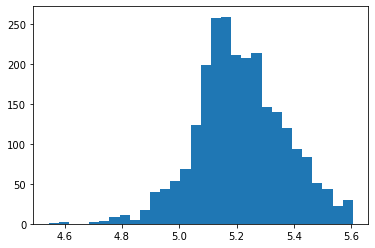

In [30]:
plt.hist(merged1['saleprice'], bins=30)

Target feature is less skewed after log transformation.

## Modeling Data Set

In [31]:
merged1.head()

,pid,grlivarea,saleprice,lotfrontage,lotarea,overallqual,overallcond,yearbuilt,yearremodadd,masvnrarea,exterqual,extercond,bsmtfinsf1,bsmtfinsf2,bsmtunfsf,totalbsmtsf,heatingqc,1stflrsf,2ndflrsf,lowqualfinsf,bsmtfullbath,bsmthalfbath,fullbath,halfbath,bedroomabvgr,kitchenabvgr,kitchenqual,totrmsabvgrd,fireplaces,garageyrblt,garagecars,garagearea,wooddecksf,openporchsf,enclosedporch,3ssnporch,screenporch,poolarea,miscval,yrsold,price_sqft,house_age,reno_age,bbratio_abvgr,tporch,mssubclass_30,mssubclass_40,mssubclass_45,mssubclass_50,mssubclass_60,...,bsmtfintype1_LwQ,bsmtfintype1_No Bsmt,bsmtfintype1_Rec,bsmtfintype1_Unf,bsmtfintype2_ALQ,bsmtfintype2_BLQ,bsmtfintype2_GLQ,bsmtfintype2_LwQ,bsmtfintype2_No Bsmt,bsmtfintype2_Rec,heating_Others,centralair_N,electrical_Fuse,functional_Min,functional_Mod_more,fireplacequ_Abv_Avg,fireplacequ_Blw_Avg,fireplacequ_TA,garagetype_BuiltIn,garagetype_Detchd,garagetype_No Garage,garagetype_Others,garagefinish_Fin,garagefinish_No Garage,garagefinish_RFn,garagequal_Abv_Avg,garagequal_Blw_Avg,garagequal_No Garage,garagecond_Abv_Avg,garagecond_Blw_Avg,garagecond_No Garage,paveddrive_N,paveddrive_P,poolqc_Ex,poolqc_Fa,poolqc_Gd,poolqc_TA,fence_GdPrv,fence_GdWo,fence_MnPrv,fence_MnWw,miscfeature_Yes,mosold_QT1,mosold_QT3,mosold_QT4,saletype_COD,saletype_New,saletype_others,salecondition_Partial,salecondition_others
0,909176150,-1.321797,5.100371,-1.670999,-0.257147,-0.013472,0.331021,-1.059906,-1.648563,-0.565983,-0.663647,-0.251528,-0.468331,-0.306176,0.183398,-0.424220,-1.187998,-0.773712,-0.799040,-0.095055,1.115682,-0.254234,-1.006807,-0.753530,-1.046989,-0.198767,-0.741857,-1.567721,0.631364,0.136436,0.363424,-0.313564,-0.740003,-0.703450,-0.357959,-0.101803,2.700869,-0.054509,-0.099465,1.644763,0.928655,1.132731,1.758026,-0.710375,-0.092937,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
1,905476230,-0.905927,5.144574,-0.407836,-0.706108,-0.782611,-0.566943,0.466115,0.016014,0.353362,1.196231,-0.251528,0.299072,1.963330,-1.025400,0.067036,-1.187998,-0.228849,-0.799040,-0.095055,1.115682,-0.254234,0.843276,-0.753530,-1.046989,-0.198767,0.867029,-0.900923,-0.931135,0.242243,-1.015564,-0.973524,-0.740003,0.920310,-0.357959,-0.101803,-0.279143,-0.054509,-0.099465,0.881023,0.437003,-0.426918,0.040517,-1.217411,-0.480952,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
3,911128020,-1.009355,5.096562,0.133520,-0.481935,-0.782611,3.024913,-1.365111,1.142051,-0.565983,1.196231,-0.251528,0.751204,-0.306176,-1.034807,-0.472582,0.906462,-0.364359,-0.799040,-0.095055,-0.829630,-0.254234,-1.006807,-0.753530,-1.046989,-0.198767,0.867029,-0.900923,-0.931135,0.115274,-1.015564,-1.221629,0.471896,-0.703450,0.298589,3.215634,-0.279143,-0.054509,-0.099465,-0.646457,0.153043,1.336163,-1.186276,0.810730,0.644929,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
4,535377150,-0.927474,5.056905,0.735026,-0.225702,-1.551750,2.126949,-2.382459,0.946218,-0.565983,1.196231,2.433256,-1.049993,-0.306176,-0.317524,-1.572180,-0.140768,-1.166126,-0.031432,-0.095055,-0.829630,-0.254234,-1.006807,-0.753530,-1.046989,-0.198767,-0.741857,-0.234126,-0.931135,0.138787,-1.015564,-0.899093,-0.740003,-0.703450,2.268230,-0.101803,1.713516,-0.054509,-0.099465,0.881023,-0.367732,2.421136,-0.891846,0.810730,0.625846,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,534177230,0.421410,5.356026,0.434273,-0.194502,1.524807,0.331021,1.042612,0.848302,-0.565983,1.196231,-0.251528,0.521472,-0.306176,-0.877240,-0.541307,0.906462,-0.903575,1.239174,-0.095055,1.115682,-0.254234,0.843276,1.248544,0.186980,-0.198767,0.867029,-0.234126,-0.931135,0.282214,0.363424,0.326547,-0.740003,-0.007553,-0.357959,-0.101803,-0.279143,-0.054509,-0.099465,0.881023,0.552977,-1.003310,-0.793702,-0.927676,-0.8626

In [217]:
merged3.head()

,pid,grlivarea,saleprice,lotfrontage,lotarea,overallqual,overallcond,yearbuilt,yearremodadd,masvnrarea,exterqual,extercond,bsmtfinsf1,bsmtfinsf2,bsmtunfsf,totalbsmtsf,heatingqc,1stflrsf,2ndflrsf,lowqualfinsf,bsmtfullbath,bsmthalfbath,fullbath,halfbath,bedroomabvgr,kitchenabvgr,kitchenqual,totrmsabvgrd,fireplaces,garageyrblt,garagecars,garagearea,wooddecksf,openporchsf,enclosedporch,3ssnporch,screenporch,poolarea,miscval,yrsold,price_sqft,house_age,reno_age,bbratio_abvgr,tporch,nbhd_above_uoi,nbhd_below_uoi,nbhd_above_dot,nbhd_below_dot,mssubclass_30,...,bsmtfintype1_LwQ,bsmtfintype1_No Bsmt,bsmtfintype1_Rec,bsmtfintype1_Unf,bsmtfintype2_ALQ,bsmtfintype2_BLQ,bsmtfintype2_GLQ,bsmtfintype2_LwQ,bsmtfintype2_No Bsmt,bsmtfintype2_Rec,heating_Others,centralair_N,electrical_Fuse,functional_Min,functional_Mod_more,fireplacequ_Abv_Avg,fireplacequ_Blw_Avg,fireplacequ_TA,garagetype_BuiltIn,garagetype_Detchd,garagetype_No Garage,garagetype_Others,garagefinish_Fin,garagefinish_No Garage,garagefinish_RFn,garagequal_Abv_Avg,garagequal_Blw_Avg,garagequal_No Garage,garagecond_Abv_Avg,garagecond_Blw_Avg,garagecond_No Garage,paveddrive_N,paveddrive_P,poolqc_Ex,poolqc_Fa,poolqc_Gd,poolqc_TA,fence_GdPrv,fence_GdWo,fence_MnPrv,fence_MnWw,miscfeature_Yes,mosold_QT1,mosold_QT3,mosold_QT4,saletype_COD,saletype_New,saletype_others,salecondition_Partial,salecondition_others
0,909176150,-1.321797,5.100371,-1.670999,-0.257147,-0.013472,0.331021,-1.059906,-1.648563,-0.565983,-0.663647,-0.251528,-0.468331,-0.306176,0.183398,-0.424220,-1.187998,-0.773712,-0.799040,-0.095055,1.115682,-0.254234,-1.006807,-0.753530,-1.046989,-0.198767,-0.741857,-1.567721,0.631364,0.136436,0.363424,-0.313564,-0.740003,-0.703450,-0.357959,-0.101803,2.700869,-0.054509,-0.099465,1.644763,0.928655,1.132731,1.758026,-0.710375,-0.092937,0,1,0,1,1,...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
1,905476230,-0.905927,5.144574,-0.407836,-0.706108,-0.782611,-0.566943,0.466115,0.016014,0.353362,1.196231,-0.251528,0.299072,1.963330,-1.025400,0.067036,-1.187998,-0.228849,-0.799040,-0.095055,1.115682,-0.254234,0.843276,-0.753530,-1.046989,-0.198767,0.867029,-0.900923,-0.931135,0.242243,-1.015564,-0.973524,-0.740003,0.920310,-0.357959,-0.101803,-0.279143,-0.054509,-0.099465,0.881023,0.437003,-0.426918,0.040517,-1.217411,-0.480952,0,1,0,1,0,...,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
3,911128020,-1.009355,5.096562,0.133520,-0.481935,-0.782611,3.024913,-1.365111,1.142051,-0.565983,1.196231,-0.251528,0.751204,-0.306176,-1.034807,-0.472582,0.906462,-0.364359,-0.799040,-0.095055,-0.829630,-0.254234,-1.006807,-0.753530,-1.046989,-0.198767,0.867029,-0.900923,-0.931135,0.115274,-1.015564,-1.221629,0.471896,-0.703450,0.298589,3.215634,-0.279143,-0.054509,-0.099465,-0.646457,0.153043,1.336163,-1.186276,0.810730,0.644929,0,1,0,1,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
4,535377150,-0.927474,5.056905,0.735026,-0.225702,-1.551750,2.126949,-2.382459,0.946218,-0.565983,1.196231,2.433256,-1.049993,-0.306176,-0.317524,-1.572180,-0.140768,-1.166126,-0.031432,-0.095055,-0.829630,-0.254234,-1.006807,-0.753530,-1.046989,-0.198767,-0.741857,-0.234126,-0.931135,0.138787,-1.015564,-0.899093,-0.740003,-0.703450,2.268230,-0.101803,1.713516,-0.054509,-0.099465,0.881023,-0.367732,2.421136,-0.891846,0.810730,0.625846,0,1,0,1,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,534177230,0.421410,5.356026,0.434273,-0.194502,1.524807,0.331021,1.042612,0.848302,-0.565983,1.196231,-0.251528,0.521472,-0.306176,-0.877240,-0.541307,0.906462,-0.903575,1.239174,-0.095055,1.115682,-0.254234,0.843276,1.248544,0.186980,-0.198767,0.867029,-0.234126,-0.931135,0.282214,0.363424,0.326547,-0.740003,-0.007553,-0.357959,-0.101803,-0.279143,-0.054509,-0.099465,0.881023,0.552977,-1.003310,-0.793702,-0.927676,-0.

## Lasso Model

### Lasso Cross Validation

In [219]:
target = merged1['saleprice']
features = ['grlivarea','lotfrontage','lotarea','overallqual','overallcond','yearbuilt','yearremodadd','masvnrarea',
            'exterqual','extercond','bsmtfinsf1','bsmtfinsf2','bsmtunfsf','totalbsmtsf','heatingqc','1stflrsf',
            '2ndflrsf','lowqualfinsf','bsmtfullbath','bsmthalfbath','fullbath','halfbath','bedroomabvgr','kitchenabvgr',
            'kitchenqual','totrmsabvgrd','fireplaces','garageyrblt','garagecars','garagearea','wooddecksf','openporchsf',
            'enclosedporch','3ssnporch','screenporch','poolarea','miscval','yrsold','house_age','reno_age','bbratio_abvgr',
            'tporch','mssubclass_30','mssubclass_40','mssubclass_45','mssubclass_50','mssubclass_60','mssubclass_70',
            'mssubclass_75','mssubclass_80','mssubclass_85','mssubclass_90','mssubclass_120','mssubclass_150',
            'mssubclass_160','mssubclass_180','mssubclass_190','mszoning_RM','mszoning_others','street_Grvl','alley_others',
            'lotshape_IR','landcontour_others','utilities_NoSewr','lotconfig_Corner','lotconfig_CulDSac','lotconfig_FR2',
            'lotconfig_FR3','landslope_Mod','landslope_Sev','neighborhood_nbhd_ne','neighborhood_nbhd_se','neighborhood_nbhd_sw',
            'neighborhood_nbhd_west','condition1_others','condition2_others','bldgtype_2fmCon','bldgtype_Duplex',
            'bldgtype_Twnhs','bldgtype_TwnhsE','housestyle_1.5Fin','housestyle_2Story','housestyle_SFoyer','housestyle_SLvl',
            'housestyle_others','roofstyle_others','roofmatl_others','exterior1st_BrkFace','exterior1st_CemntBd',
            'exterior1st_HdBoard','exterior1st_MetalSd','exterior1st_Others','exterior1st_Plywood','exterior1st_Stucco',
            'exterior1st_Wd Sdng','exterior1st_WdShing','exterior2nd_AsbShng','exterior2nd_AsphShn','exterior2nd_Brk Cmn',
            'exterior2nd_BrkFace','exterior2nd_CBlock','exterior2nd_CmentBd','exterior2nd_HdBoard','exterior2nd_ImStucc',
            'exterior2nd_MetalSd','exterior2nd_Plywood','exterior2nd_PreCast','exterior2nd_Stone','exterior2nd_Stucco',
            'exterior2nd_Wd Sdng','exterior2nd_Wd Shng','masvnrtype_BrkCmn','masvnrtype_BrkFace','masvnrtype_Missing',
            'masvnrtype_Stone','foundation_BrkTil','foundation_Others','foundation_PConc','bsmtqual_Blw_Avg','bsmtqual_No Bsmt',
            'bsmtqual_TA','bsmtcond_Abv_Avg','bsmtcond_Blw_Avg','bsmtcond_No Bsmt','bsmtexposure_Av','bsmtexposure_Gd',
            'bsmtexposure_Mn','bsmtexposure_No Bsmt','bsmtfintype1_ALQ','bsmtfintype1_BLQ','bsmtfintype1_LwQ','bsmtfintype1_No Bsmt',
            'bsmtfintype1_Rec','bsmtfintype1_Unf','bsmtfintype2_ALQ','bsmtfintype2_BLQ','bsmtfintype2_GLQ','bsmtfintype2_LwQ',
            'bsmtfintype2_No Bsmt','bsmtfintype2_Rec','heating_Others','centralair_N','electrical_Fuse','functional_Min',
            'functional_Mod_more','fireplacequ_Abv_Avg','fireplacequ_Blw_Avg','fireplacequ_TA','garagetype_BuiltIn',
            'garagetype_Detchd','garagetype_No Garage','garagetype_Others','garagefinish_Fin','garagefinish_No Garage',
            'garagefinish_RFn','garagequal_Abv_Avg','garagequal_Blw_Avg','garagequal_No Garage','garagecond_Abv_Avg',
            'garagecond_Blw_Avg','garagecond_No Garage','paveddrive_N','paveddrive_P','poolqc_Ex','poolqc_Fa','poolqc_Gd',
            'poolqc_TA','fence_GdPrv','fence_GdWo','fence_MnPrv','fence_MnWw','miscfeature_Yes','mosold_QT1','mosold_QT3',
            'mosold_QT4','saletype_COD','saletype_New','saletype_others','salecondition_Partial','salecondition_others']
X_feature = merged1[features]

### Model 1 with grouping 1

In [278]:
from sklearn.linear_model import LassoCV
lasso_cv = LassoCV(cv=5, random_state=0)

intercepts = []
R2  = []
coefs_dict = {}
MSE = []


alphaRange = np.logspace(-5,-2,20)
for alpha in alphaRange:
    lasso_cv.set_params(alphas=[alpha])  
    lasso_cv.fit(X_feature, target)
    intercepts.append(lasso_cv.intercept_)
    coefs_dict[alpha] = lasso_cv.coef_
    R2.append(lasso_cv.score(X_feature, target)) 
    MSE.append(lasso_cv.mse_path_.mean())
    

C:\Users\Chun\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.18398583449716632, tolerance: 0.004558130538216861

C:\Users\Chun\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.46526975023894357, tolerance: 0.004589905973936366

C:\Users\Chun\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5696009215489788, tolerance: 0.004697277736256464

C:\Users\Chun\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.2458859475619

In [279]:
for i in range(20):
    alpha = alphaRange[i]
    coef_alpha = coefs_dict[alpha]
    print(i, round(alpha,5), len(coef_alpha[coef_alpha!=0]),round(R2[i],5), round(MSE[i],6))

0 1e-05 159 0.92873 0.002126
1 1e-05 151 0.92859 0.002116
2 2e-05 148 0.92834 0.002106
3 3e-05 142 0.92792 0.002093
4 4e-05 136 0.92751 0.002082
5 6e-05 128 0.92686 0.002073
6 9e-05 112 0.92609 0.002067
7 0.00013 101 0.925 0.00206
8 0.00018 88 0.92363 0.002058
9 0.00026 77 0.9217 0.002064
10 0.00038 63 0.91922 0.002088
11 0.00055 50 0.91674 0.002129
12 0.00078 43 0.91353 0.002195
13 0.00113 37 0.90943 0.002275
14 0.00162 32 0.90572 0.002359
15 0.00234 28 0.90212 0.002437
16 0.00336 23 0.89839 0.002517
17 0.00483 22 0.89226 0.002656
18 0.00695 19 0.88537 0.00282
19 0.01 17 0.87251 0.003123


In [280]:
coef_alpha8 = pd.DataFrame({'feature':X_feature.columns, 'coef':coefs_dict[alphaRange[8]]})
coef_alpha8['importance'] = abs(coef_alpha8['coef'])
coef_alpha8[['feature','importance']].loc[coef_alpha8.coef != 0].sort_values(by='importance',ascending=False)

,feature,importance
0,grlivarea,0.047292
3,overallqual,0.031905
144,functional_Mod_more,0.030474
78,bldgtype_Twnhs,0.027868
75,condition2_others,0.023454
54,mssubclass_160,0.022801
70,neighborhood_nbhd_ne,0.022246
57,mszoning_RM,0.022216
74,condition1_others,0.021113
87,exterior1st_BrkFace,0.020223


In [281]:
picked_feature = coef_alpha8.loc[coef_alpha8.coef != 0,'feature'].tolist()
picked = X_feature[picked_feature]
picked.columns

Index(['grlivarea', 'lotfrontage', 'lotarea', 'overallqual', 'overallcond',
       'yearbuilt', 'exterqual', 'extercond', 'bsmtfinsf1', 'bsmtfinsf2',
       'totalbsmtsf', 'heatingqc', '1stflrsf', 'lowqualfinsf', 'bsmtfullbath',
       'fullbath', 'halfbath', 'bedroomabvgr', 'kitchenabvgr', 'kitchenqual',
       'totrmsabvgrd', 'fireplaces', 'garageyrblt', 'garagecars', 'garagearea',
       'openporchsf', 'enclosedporch', '3ssnporch', 'screenporch', 'miscval',
       'house_age', 'reno_age', 'bbratio_abvgr', 'tporch', 'mssubclass_30',
       'mssubclass_50', 'mssubclass_60', 'mssubclass_70', 'mssubclass_85',
       'mssubclass_160', 'mszoning_RM', 'mszoning_others', 'lotshape_IR',
       'landcontour_others', 'lotconfig_CulDSac', 'lotconfig_FR2',
       'landslope_Mod', 'neighborhood_nbhd_ne', 'neighborhood_nbhd_se',
       'neighborhood_nbhd_west', 'condition1_others', 'condition2_others',
       'bldgtype_Twnhs', 'bldgtype_TwnhsE', 'roofmatl_others',
       'exterior1st_BrkFace', 'ex

In [282]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

X_feature['constant'] = 1
#calculate VIF for each explanatory variable
vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(picked.values, i) for i in range(picked.shape[1])]
vif['variable'] = picked.columns

#view VIF for each explanatory variable 

In [283]:
vif[vif['VIF']>5]

,VIF,variable
0,10.930885,grlivarea
5,548.845807,yearbuilt
10,5.972071,totalbsmtsf
12,8.497359,1stflrsf
15,5.676028,fullbath
17,5.589266,bedroomabvgr
23,6.539779,garagecars
24,5.836276,garagearea
30,542.455181,house_age
32,6.686431,bbratio_abvgr


#### Removing 'yearbuilt', 'totalbsmtsf' , 'fullbath', ' garagearea'

In [284]:
X2 = merged1[['grlivarea', 'lotfrontage', 'lotarea', 'overallqual', 'overallcond',
       'exterqual', 'extercond', 'bsmtfinsf1', 'bsmtfinsf2',
        'heatingqc', '1stflrsf', 'lowqualfinsf', 'bsmtfullbath',
       'halfbath', 'bedroomabvgr', 'kitchenabvgr', 'kitchenqual',
       'totrmsabvgrd', 'fireplaces', 'garageyrblt', 'garagecars',
       'openporchsf', 'enclosedporch', '3ssnporch', 'screenporch', 'miscval',
       'house_age', 'reno_age', 'bbratio_abvgr', 'tporch', 'mssubclass_30',
       'mssubclass_50', 'mssubclass_60', 'mssubclass_70', 'mssubclass_85',
       'mssubclass_160', 'mszoning_RM', 'mszoning_others', 'lotshape_IR',
       'landcontour_others', 'lotconfig_CulDSac', 'lotconfig_FR2',
       'landslope_Mod', 'neighborhood_nbhd_ne', 'neighborhood_nbhd_se',
       'neighborhood_nbhd_west', 'condition1_others', 'condition2_others',
       'bldgtype_Twnhs', 'bldgtype_TwnhsE', 'roofmatl_others',
       'exterior1st_BrkFace', 'exterior1st_CemntBd', 'exterior1st_Plywood',
       'exterior2nd_AsbShng', 'exterior2nd_Plywood', 'masvnrtype_BrkFace',
       'foundation_PConc', 'bsmtcond_Abv_Avg', 'bsmtexposure_Av',
       'bsmtexposure_Gd', 'bsmtexposure_Mn', 'bsmtexposure_No Bsmt',
       'bsmtfintype1_LwQ', 'bsmtfintype1_Rec', 'bsmtfintype1_Unf',
       'bsmtfintype2_BLQ', 'bsmtfintype2_Rec', 'centralair_N',
       'functional_Min', 'functional_Mod_more', 'fireplacequ_Abv_Avg',
       'garagetype_BuiltIn', 'garagetype_Others', 'garagefinish_Fin',
       'garagefinish_RFn', 'garagecond_Blw_Avg', 'paveddrive_N', 'fence_MnPrv',
       'mosold_QT1', 'mosold_QT3', 'mosold_QT4', 'salecondition_Partial',
       'salecondition_others']]

In [285]:
from sklearn.linear_model import LassoCV
lasso_cv = LassoCV(cv=5, random_state=0, max_iter=3000, tol=0.1)

intercepts = []
R2  = []
coefs_dict = {}
MSE = []


alphaRange = np.logspace(-5,-2,20)
for alpha in alphaRange:
    lasso_cv.set_params(alphas=[alpha])  
    lasso_cv.fit(X2, target)
    intercepts.append(lasso_cv.intercept_)
    coefs_dict[alpha] = lasso_cv.coef_
    R2.append(lasso_cv.score(X2, target)) 
    MSE.append(lasso_cv.mse_path_.mean())

In [286]:
for i in range(20):
    alpha = alphaRange[i]
    coef_alpha = coefs_dict[alpha]
    print(i, round(alpha,5), len(coef_alpha[coef_alpha!=0]),round(R2[i],5), round(MSE[i],6))

0 1e-05 84 0.90749 0.002388
1 1e-05 84 0.90751 0.002388
2 2e-05 83 0.91252 0.002366
3 3e-05 84 0.91615 0.002365
4 4e-05 84 0.91614 0.002315
5 6e-05 82 0.91608 0.002311
6 9e-05 81 0.91593 0.002346
7 0.00013 78 0.91555 0.002302
8 0.00018 77 0.91472 0.0023
9 0.00026 71 0.91328 0.00227
10 0.00038 59 0.91379 0.002291
11 0.00055 56 0.91342 0.002296
12 0.00078 45 0.90841 0.002296
13 0.00113 34 0.90379 0.002394
14 0.00162 29 0.9004 0.002467
15 0.00234 25 0.89659 0.002557
16 0.00336 24 0.89313 0.002634
17 0.00483 22 0.88751 0.002777
18 0.00695 18 0.88022 0.00293
19 0.01 15 0.86808 0.003215


In [288]:
coef_alpha10 = pd.DataFrame({'feature':X2.columns, 'coef':coefs_dict[alphaRange[10]]})
coef_alpha10['importance'] = abs(coef_alpha10['coef'])
coef_alpha10[['feature','importance']].loc[coef_alpha10.coef != 0].sort_values(by='importance',ascending=False)

,feature,importance
0,grlivarea,0.055759
3,overallqual,0.037348
35,mssubclass_160,0.035446
26,house_age,0.032862
70,functional_Mod_more,0.026678
62,bsmtexposure_No Bsmt,0.022456
32,mssubclass_60,0.022004
48,bldgtype_Twnhs,0.021458
46,condition1_others,0.020581
36,mszoning_RM,0.020056


In [289]:
picked_feature_ = coef_alpha10.loc[coef_alpha10.coef != 0,'feature'].tolist()
picked_ = X2[picked_feature_]

In [290]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

X2['constant'] = 1
#calculate VIF for each explanatory variable
vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(picked_.values, i) for i in range(picked_.shape[1])]
vif['variable'] = picked_.columns


In [291]:
vif[vif['VIF']>5]

,VIF,variable
0,8.832999,grlivarea
25,6.430779,house_age


### Model 2 with grouping 2

In [292]:
features_ = ['grlivarea','lotfrontage','lotarea','overallqual','overallcond','yearbuilt','yearremodadd','masvnrarea',
             'exterqual','extercond','bsmtfinsf1','bsmtfinsf2','bsmtunfsf','totalbsmtsf','heatingqc','1stflrsf',
             '2ndflrsf','lowqualfinsf','bsmtfullbath','bsmthalfbath','fullbath','halfbath','bedroomabvgr','kitchenabvgr',
             'kitchenqual','totrmsabvgrd','fireplaces','garageyrblt','garagecars','garagearea','wooddecksf','openporchsf',
             'enclosedporch','3ssnporch','screenporch','poolarea','miscval','yrsold','house_age','reno_age','bbratio_abvgr',
             'tporch','nbhd_above_uoi','nbhd_below_uoi','nbhd_above_dot','nbhd_below_dot','mssubclass_30','mssubclass_40',
             'mssubclass_45','mssubclass_50','mssubclass_60','mssubclass_70','mssubclass_75','mssubclass_80','mssubclass_85',
             'mssubclass_90','mssubclass_120','mssubclass_150','mssubclass_160','mssubclass_180','mssubclass_190','mszoning_RM',
             'mszoning_others','street_Grvl','alley_others','lotshape_IR','landcontour_others','utilities_NoSewr',
             'lotconfig_Corner','lotconfig_CulDSac','lotconfig_FR2','lotconfig_FR3','landslope_Mod','landslope_Sev',
             'condition1_others','condition2_others','bldgtype_2fmCon','bldgtype_Duplex','bldgtype_Twnhs','bldgtype_TwnhsE',
             'housestyle_1.5Fin','housestyle_2Story','housestyle_SFoyer','housestyle_SLvl','housestyle_others',
             'roofstyle_others','roofmatl_others','exterior1st_BrkFace','exterior1st_CemntBd','exterior1st_HdBoard',
             'exterior1st_MetalSd','exterior1st_Others','exterior1st_Plywood','exterior1st_Stucco','exterior1st_Wd Sdng',
             'exterior1st_WdShing','exterior2nd_AsbShng','exterior2nd_AsphShn','exterior2nd_Brk Cmn','exterior2nd_BrkFace',
             'exterior2nd_CBlock','exterior2nd_CmentBd','exterior2nd_HdBoard','exterior2nd_ImStucc','exterior2nd_MetalSd',
             'exterior2nd_Plywood','exterior2nd_PreCast','exterior2nd_Stone','exterior2nd_Stucco','exterior2nd_Wd Sdng',
             'exterior2nd_Wd Shng','masvnrtype_BrkCmn','masvnrtype_BrkFace','masvnrtype_Missing','masvnrtype_Stone',
             'foundation_BrkTil','foundation_Others','foundation_PConc','bsmtqual_Blw_Avg','bsmtqual_No Bsmt','bsmtqual_TA',
             'bsmtcond_Abv_Avg','bsmtcond_Blw_Avg','bsmtcond_No Bsmt','bsmtexposure_Av','bsmtexposure_Gd','bsmtexposure_Mn',
             'bsmtexposure_No Bsmt','bsmtfintype1_ALQ','bsmtfintype1_BLQ','bsmtfintype1_LwQ','bsmtfintype1_No Bsmt',
             'bsmtfintype1_Rec','bsmtfintype1_Unf','bsmtfintype2_ALQ','bsmtfintype2_BLQ','bsmtfintype2_GLQ','bsmtfintype2_LwQ',
             'bsmtfintype2_No Bsmt','bsmtfintype2_Rec','heating_Others','centralair_N','electrical_Fuse','functional_Min',
             'functional_Mod_more','fireplacequ_Abv_Avg','fireplacequ_Blw_Avg','fireplacequ_TA','garagetype_BuiltIn','garagetype_Detchd',
             'garagetype_No Garage','garagetype_Others','garagefinish_Fin','garagefinish_No Garage','garagefinish_RFn',
             'garagequal_Abv_Avg','garagequal_Blw_Avg','garagequal_No Garage','garagecond_Abv_Avg','garagecond_Blw_Avg',
             'garagecond_No Garage','paveddrive_N','paveddrive_P','poolqc_Ex','poolqc_Fa','poolqc_Gd','poolqc_TA',
             'fence_GdPrv','fence_GdWo','fence_MnPrv','fence_MnWw','miscfeature_Yes','mosold_QT1','mosold_QT3','mosold_QT4',
             'saletype_COD','saletype_New','saletype_others','salecondition_Partial','salecondition_others']
X = merged3[features_]

In [293]:
from sklearn.linear_model import LassoCV
lasso_cv = LassoCV(cv=5, random_state=0)

intercepts = []
R2  = []
coefs_dict = {}
MSE = []


alphaRange = np.logspace(-5,-2,20)
for alpha in alphaRange:
    lasso_cv.set_params(alphas=[alpha])  
    lasso_cv.fit(X, target)
    intercepts.append(lasso_cv.intercept_)
    coefs_dict[alpha] = lasso_cv.coef_
    R2.append(lasso_cv.score(X, target)) 
    MSE.append(lasso_cv.mse_path_.mean())
    

C:\Users\Chun\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.18677961155839728, tolerance: 0.004558130538216861

C:\Users\Chun\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.23397170278974588, tolerance: 0.004589905973936366

C:\Users\Chun\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.2648588140127903, tolerance: 0.004697277736256464

C:\Users\Chun\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.2571941774059

In [294]:
for i in range(20):
    alpha = alphaRange[i]
    coef_alpha = coefs_dict[alpha]
    print(i, round(alpha,5), len(coef_alpha[coef_alpha!=0]),round(R2[i],5), round(MSE[i],6))

0 1e-05 158 0.92695 0.002169
1 1e-05 154 0.92681 0.002159
2 2e-05 149 0.92656 0.002148
3 3e-05 140 0.92618 0.002136
4 4e-05 128 0.92577 0.002125
5 6e-05 123 0.92519 0.002115
6 9e-05 113 0.92443 0.002105
7 0.00013 101 0.92343 0.002098
8 0.00018 89 0.92219 0.002095
9 0.00026 79 0.92032 0.002101
10 0.00038 65 0.91786 0.002122
11 0.00055 51 0.91543 0.00216
12 0.00078 44 0.91245 0.00222
13 0.00113 36 0.90883 0.002288
14 0.00162 32 0.90572 0.002359
15 0.00234 28 0.90212 0.002437
16 0.00336 23 0.89839 0.002517
17 0.00483 22 0.89226 0.002656
18 0.00695 19 0.88537 0.00282
19 0.01 17 0.87251 0.003123


In [295]:
coef_alpha8 = pd.DataFrame({'feature':X.columns, 'coef':coefs_dict[alphaRange[8]]})
coef_alpha8['importance'] = abs(coef_alpha8['coef'])
coef_alpha8[['feature','importance']].loc[coef_alpha8.coef != 0].sort_values(by='importance',ascending=False)

,feature,importance
0,grlivarea,4.824077e-02
3,overallqual,3.297252e-02
144,functional_Mod_more,3.155601e-02
75,condition2_others,2.451158e-02
61,mszoning_RM,2.422887e-02
58,mssubclass_160,2.212081e-02
74,condition1_others,2.163028e-02
87,exterior1st_BrkFace,2.122862e-02
4,overallcond,2.025297e-02
78,bldgtype_Twnhs,2.022839e-02


In [300]:
picked_feature = coef_alpha8.loc[coef_alpha8.coef != 0,'feature'].tolist()
picked = X[picked_feature]
picked.columns

Index(['grlivarea', 'lotfrontage', 'lotarea', 'overallqual', 'overallcond',
       'yearbuilt', 'masvnrarea', 'exterqual', 'extercond', 'bsmtfinsf1',
       'bsmtfinsf2', 'totalbsmtsf', 'heatingqc', '1stflrsf', 'lowqualfinsf',
       'bsmtfullbath', 'fullbath', 'halfbath', 'bedroomabvgr', 'kitchenabvgr',
       'kitchenqual', 'totrmsabvgrd', 'fireplaces', 'garageyrblt',
       'garagecars', 'garagearea', 'openporchsf', 'enclosedporch', '3ssnporch',
       'screenporch', 'miscval', 'house_age', 'reno_age', 'bbratio_abvgr',
       'tporch', 'nbhd_above_uoi', 'nbhd_below_uoi', 'nbhd_above_dot',
       'nbhd_below_dot', 'mssubclass_30', 'mssubclass_50', 'mssubclass_60',
       'mssubclass_70', 'mssubclass_85', 'mssubclass_160', 'mszoning_RM',
       'lotshape_IR', 'landcontour_others', 'lotconfig_CulDSac',
       'lotconfig_FR2', 'landslope_Mod', 'condition1_others',
       'condition2_others', 'bldgtype_Twnhs', 'bldgtype_TwnhsE',
       'roofmatl_others', 'exterior1st_BrkFace', 'exterior1

In [298]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

X['constant'] = 1
#calculate VIF for each explanatory variable
vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(picked.values, i) for i in range(picked.shape[1])]
vif['variable'] = picked.columns

#view VIF for each explanatory variable 

In [299]:
vif[vif['VIF']>5]

,VIF,variable
0,12.096858,grlivarea
5,550.634556,yearbuilt
13,7.905374,1stflrsf
16,5.691452,fullbath
18,5.611390,bedroomabvgr
24,6.478603,garagecars
25,5.713872,garagearea
31,545.682602,house_age
33,6.690535,bbratio_abvgr
35,inf,nbhd_above_uoi


#### Removing yearbuilt, 1stflrsf, fullbath, garagearea, nbhd_above_uoi,nbhd_above_dot

In [301]:
X22 = merged3[['grlivarea', 'lotfrontage', 'lotarea', 'overallqual', 'overallcond',
       'masvnrarea', 'exterqual', 'extercond', 'bsmtfinsf1',
       'bsmtfinsf2', 'totalbsmtsf', 'heatingqc', '1stflrsf', 'lowqualfinsf',
       'bsmtfullbath', 'halfbath', 'bedroomabvgr', 'kitchenabvgr',
       'kitchenqual', 'totrmsabvgrd', 'fireplaces', 'garageyrblt',
       'garagecars', 'openporchsf', 'enclosedporch', '3ssnporch',
       'screenporch', 'miscval', 'house_age', 'reno_age', 'bbratio_abvgr',
       'tporch',  'nbhd_below_uoi',
       'nbhd_below_dot', 'mssubclass_30', 'mssubclass_50', 'mssubclass_60',
       'mssubclass_70', 'mssubclass_85', 'mssubclass_160', 'mszoning_RM',
       'lotshape_IR', 'landcontour_others', 'lotconfig_CulDSac',
       'lotconfig_FR2', 'landslope_Mod', 'condition1_others',
       'condition2_others', 'bldgtype_Twnhs', 'bldgtype_TwnhsE',
       'roofmatl_others', 'exterior1st_BrkFace', 'exterior1st_CemntBd',
       'exterior1st_HdBoard', 'exterior1st_MetalSd', 'exterior1st_Plywood',
       'exterior2nd_AsbShng', 'exterior2nd_Plywood', 'foundation_PConc',
       'bsmtcond_Abv_Avg', 'bsmtexposure_Av', 'bsmtexposure_Gd',
       'bsmtexposure_Mn', 'bsmtfintype1_LwQ', 'bsmtfintype1_Rec',
       'bsmtfintype1_Unf', 'bsmtfintype2_BLQ', 'bsmtfintype2_Rec',
       'centralair_N', 'functional_Min', 'functional_Mod_more',
       'fireplacequ_Abv_Avg', 'garagetype_BuiltIn', 'garagetype_Others',
       'garagefinish_Fin', 'garagefinish_RFn', 'garagecond_Blw_Avg',
       'paveddrive_N', 'fence_MnPrv', 'mosold_QT1', 'mosold_QT3', 'mosold_QT4',
       'salecondition_Partial', 'salecondition_others']]

In [302]:
from sklearn.linear_model import LassoCV
lasso_cv = LassoCV(cv=5, random_state=0, max_iter=3000, tol=0.1)

intercepts = []
R2  = []
coefs_dict = {}
MSE = []


alphaRange = np.logspace(-5,-2,20)
for alpha in alphaRange:
    lasso_cv.set_params(alphas=[alpha])  
    lasso_cv.fit(X22, target)
    intercepts.append(lasso_cv.intercept_)
    coefs_dict[alpha] = lasso_cv.coef_
    R2.append(lasso_cv.score(X22, target)) 
    MSE.append(lasso_cv.mse_path_.mean())

In [303]:
for i in range(20):
    alpha = alphaRange[i]
    coef_alpha = coefs_dict[alpha]
    print(i, round(alpha,5), len(coef_alpha[coef_alpha!=0]),round(R2[i],5), round(MSE[i],5))

0 1e-05 84 0.90932 0.00249
1 1e-05 84 0.90934 0.00249
2 2e-05 83 0.90937 0.00249
3 3e-05 83 0.90941 0.00247
4 4e-05 82 0.90944 0.00246
5 6e-05 80 0.91389 0.00241
6 9e-05 78 0.91375 0.00239
7 0.00013 77 0.91642 0.00233
8 0.00018 73 0.91279 0.00229
9 0.00026 69 0.91159 0.00229
10 0.00038 60 0.91219 0.00233
11 0.00055 47 0.91136 0.00232
12 0.00078 42 0.90972 0.0023
13 0.00113 33 0.90631 0.00234
14 0.00162 28 0.90358 0.0024
15 0.00234 26 0.89994 0.00248
16 0.00336 24 0.89674 0.00255
17 0.00483 21 0.89145 0.0027
18 0.00695 20 0.88487 0.00285
19 0.01 16 0.87218 0.00313


In [305]:
coef_alpha9 = pd.DataFrame({'feature':X22.columns, 'coef':coefs_dict[alphaRange[9]]})
coef_alpha9['weight'] = abs(coef_alpha9['coef'])
coef_alpha9['sign'] = coef_alpha9['coef'].mask(coef_alpha9['coef']>0,'P').mask(coef_alpha9['coef']<0,'N')
coef_alpha9[['feature','weight','sign']].loc[coef_alpha9.coef != 0].sort_values(by='weight',ascending=False)

,feature,weight,sign
0,grlivarea,0.069592,P
39,mssubclass_160,0.039900,N
3,overallqual,0.039534,P
70,functional_Mod_more,0.031152,N
36,mssubclass_60,0.031150,N
28,house_age,0.025631,N
40,mszoning_RM,0.023971,N
48,bldgtype_Twnhs,0.021614,N
47,condition2_others,0.020212,N
46,condition1_others,0.019261,N


In [306]:
picked_feature2 = coef_alpha9.loc[coef_alpha9.coef != 0,'feature'].tolist()

In [307]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

X22['constant'] = 1
#calculate VIF for each explanatory variable
vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(X22.values, i) for i in range(X22.shape[1])]
vif['variable'] = X2.columns

#view VIF for each explanatory variable 

In [308]:
vif[vif['VIF']>5]

,VIF,variable
0,11.307767,grlivarea
12,7.896167,bsmtfullbath
28,8.425905,bbratio_abvgr
36,5.294066,mszoning_RM
84,23.277565,constant


After removing the redundant features, the second model still shows good performance in terms of variance explained.

In [311]:
lasso_cv.set_params(alphas=[alphaRange[9]])  
lasso_cv.fit(X22, target)
lasso_cv.score(X22, target)

0.9115947463986216

## Check Assumptions

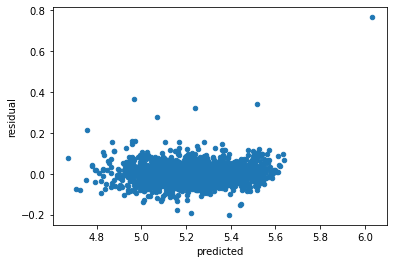

In [312]:
pd.DataFrame({'residual' : (lasso_cv.predict(X22)-target),\
              'predicted' : lasso_cv.predict(X22)}).plot(y='residual',x='predicted',kind='scatter')

In [314]:
predicted_quantile = []
residual_quantile = []
for i in np.linspace(0,1,100):
    predicted_quantile.append((lasso_cv.predict(X22)-target).quantile(i))
    residual_quantile.append(np.quantile(lasso_cv.predict(X22),i))

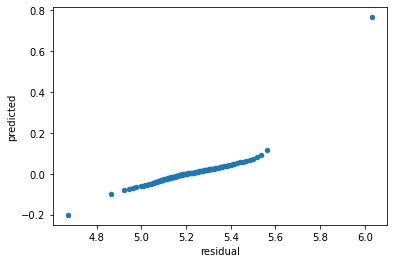

In [315]:
pd.DataFrame({'residual' : residual_quantile,\
              'predicted' : predicted_quantile}).plot(x='residual',y='predicted',kind='scatter')

In [318]:
for i, res in enumerate((lasso_cv.predict(X22)-target).tolist()):
    if res > 0.6:
        print(i)

281


In [319]:
merged.iloc[[281]]

,pid,grlivarea,saleprice,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,lotconfig,landslope,neighborhood,condition1,condition2,bldgtype,housestyle,overallqual,overallcond,yearbuilt,yearremodadd,roofstyle,roofmatl,exterior1st,exterior2nd,masvnrtype,masvnrarea,exterqual,extercond,foundation,bsmtqual,bsmtcond,bsmtexposure,bsmtfintype1,bsmtfinsf1,bsmtfintype2,bsmtfinsf2,bsmtunfsf,totalbsmtsf,heating,heatingqc,centralair,electrical,1stflrsf,2ndflrsf,lowqualfinsf,bsmtfullbath,bsmthalfbath,fullbath,halfbath,bedroomabvgr,kitchenabvgr,kitchenqual,totrmsabvgrd,functional,fireplaces,fireplacequ,garagetype,garageyrblt,garagefinish,garagecars,garagearea,garagequal,garagecond,paveddrive,wooddecksf,openporchsf,enclosedporch,3ssnporch,screenporch,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,price_sqft,house_age,reno_age,bbratio_abvgr,tporch
287,908154205,4676,184750,60,RL,130.0,40094,Pave,No Alley,IR,others,AllPub,Inside,Gtl,nbhd_west,others,others,1Fam,2Story,10,5,2007,2008,others,CompShg,CemntBd,CmentBd,Stone,762.0,5,3,PConc,Abv_Avg,TA,Gd,GLQ,2260.0,Unf,0.0,878.0,3138.0,GasA,5,Y,SBrkr,3138,1538,0,1.0,0.0,3,1,3,1,5,11,Typ,1,Abv_Avg,BuiltIn,2007.0,Fin,3.0,884.0,TA,TA,Y,208,406,0,0,0,0,No Pool,No Fence,None,0,QT4,2007,New,Partial,39.510265,0,0,0.666667,614


## Data Analysis 

Features have coefficents larger than 0.01: 

'grlivarea', 'overallqual', 'mszoning_RM', 'house_age', 

'totalbsmtsf', 'overallcond', 'condition1_others', 

'bsmtfinsf1', 'garagecars', 'heatingqc', 'fireplaces'.

In [56]:
top_features = merged[['grlivarea', 'overallqual', 'mszoning', 'house_age', \
                       'totalbsmtsf', 'overallcond', 'condition1', \
                       'bsmtfinsf1', 'garagecars', 'heatingqc', 'fireplaces',\
                       'saleprice','price_sqft','neighborhood']]

In [57]:
corr = top_features.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

,grlivarea,overallqual,house_age,totalbsmtsf,overallcond,bsmtfinsf1,garagecars,heatingqc,fireplaces,saleprice,price_sqft
grlivarea,1.00,0.53,-0.21,0.35,-0.11,0.10,0.47,0.26,0.44,0.70,-0.21
overallqual,0.53,1.00,-0.57,0.48,-0.11,0.21,0.56,0.43,0.36,0.79,0.45
house_age,-0.21,-0.57,1.00,-0.38,0.40,-0.27,-0.51,-0.41,-0.15,-0.57,-0.54
totalbsmtsf,0.35,0.48,-0.38,1.00,-0.19,0.46,0.41,0.21,0.29,0.61,0.42
overallcond,-0.11,-0.11,0.40,-0.19,1.00,-0.05,-0.20,-0.01,-0.04,-0.11,0.03
bsmtfinsf1,0.10,0.21,-0.27,0.46,-0.05,1.00,0.21,0.06,0.25,0.39,0.44
garagecars,0.47,0.56,-0.51,0.41,-0.20,0.21,1.00,0.30,0.29,0.65,0.34
heatingqc,0.26,0.43,-0.41,0.21,-0.01,0.06,0.30,1.00,0.11,0.44,0.30
fireplaces,0.44,0.36,-0.15,0.29,-0.04,0.25,0.29,0.11,1.00,0.48,0.13
saleprice,0.70,0.79,-0.57,0.61,-0.11,0.39,0.65,0.44,0.48,1.00,0.52


## Quality-related Features

In [58]:
merged[['overallqual','heatingqc','kitchenqual','exterqual']].corr()

,overallqual,heatingqc,kitchenqual,exterqual
overallqual,1.000000,0.427750,0.631422,0.690570
heatingqc,0.427750,1.000000,0.477749,0.494667
kitchenqual,0.631422,0.477749,1.000000,0.679282
exterqual,0.690570,0.494667,0.679282,1.000000


In [59]:
overall = merged1[['overallqual']]
import statsmodels.api as sm 
X_add_const = sm.add_constant(overall)
ols = sm.OLS(target, X_add_const)
ans = ols.fit()
print(ans.summary())

                            OLS Regression Results                            
Dep. Variable:              saleprice   R-squared:                       0.639
Model:                            OLS   Adj. R-squared:                  0.639
Method:                 Least Squares   F-statistic:                     4345.
Date:                Sat, 28 Nov 2020   Prob (F-statistic):               0.00
Time:                        13:44:04   Log-Likelihood:                 2356.2
No. Observations:                2455   AIC:                            -4708.
Df Residuals:                    2453   BIC:                            -4697.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           5.2133      0.002   2786.248      

In [60]:
kitchen = merged1[['kitchenqual']]
import statsmodels.api as sm 
X_add_const = sm.add_constant(kitchen)
ols = sm.OLS(target, X_add_const)
ans = ols.fit()
print(ans.summary())

                            OLS Regression Results                            
Dep. Variable:              saleprice   R-squared:                       0.397
Model:                            OLS   Adj. R-squared:                  0.396
Method:                 Least Squares   F-statistic:                     1613.
Date:                Sat, 28 Nov 2020   Prob (F-statistic):          1.88e-271
Time:                        13:44:04   Log-Likelihood:                 1725.2
No. Observations:                2455   AIC:                            -3446.
Df Residuals:                    2453   BIC:                            -3435.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           5.2133      0.002   2154.734      

In [61]:
heating = merged1[['heatingqc']]
import statsmodels.api as sm 
X_add_const = sm.add_constant(heating)
ols = sm.OLS(target, X_add_const)
ans = ols.fit()
print(ans.summary())

                            OLS Regression Results                            
Dep. Variable:              saleprice   R-squared:                       0.213
Model:                            OLS   Adj. R-squared:                  0.212
Method:                 Least Squares   F-statistic:                     663.0
Date:                Sat, 28 Nov 2020   Prob (F-statistic):          1.30e-129
Time:                        13:44:04   Log-Likelihood:                 1398.7
No. Observations:                2455   AIC:                            -2793.
Df Residuals:                    2453   BIC:                            -2782.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.2133      0.003   1886.365      0.0

In the final lasso model, the heating quality feature has a higher coefficient than kitchen quality, which indictating when keeps all other factors constant, the heating quality has bigger influence on the saleprice than the kitchen quality. 

However, in single linear regression models, the kitchen quality feature can explain more variance than the heating quality feature. This contradiction suggests that relatively more of the kitchen qulity's explination power is shared with overall quality feature, while the heating system is relatively independent and it contribution unique explaination power to the model. 

In [62]:
Q4 = merged1[['heatingqc','kitchenqual','functional_Min','functional_Mod_more',\
              'fireplacequ_Abv_Avg','fireplacequ_Blw_Avg','fireplacequ_TA','exterqual']]
target_qual = merged[['overallqual']]
import statsmodels.api as sm 
X_add_const = sm.add_constant(Q4)
ols = sm.OLS(target_qual, X_add_const)
ans = ols.fit()
print(ans.summary())

                            OLS Regression Results                            
Dep. Variable:            overallqual   R-squared:                       0.591
Model:                            OLS   Adj. R-squared:                  0.590
Method:                 Least Squares   F-statistic:                     442.6
Date:                Sat, 28 Nov 2020   Prob (F-statistic):               0.00
Time:                        13:44:04   Log-Likelihood:                -3028.7
No. Observations:                2455   AIC:                             6075.
Df Residuals:                    2446   BIC:                             6128.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   5.7329    

When we use heating quality, kitchen quality, fireplce quality, functionality, and exterior quality as independent variables to perdict overall quality, the heating quality and kitchen quality have less inflence on the overall quality, which also explains why the two features suivive in the lasso model. 

##### As business suggeation, we would recommend:

##### 1. improving the heating system can directly  increase the saleprice. ( \\$3,000 ~ \\$10,000) -- improve 2~ 3% house price.

##### 2. Secondly, house sellers should consider renovating their kitchen, it will also improve the saleprice directy, but with slightly less effect.  ( \\$3,500 ~ \\$20,000+)  --- improve 1~ 2% house price
 
##### 3. With extra budget, house sellers may consider improving the functional deficits of the house, since the deduction on such property will decrease the house price severely. 

##### 4. If it is a house with fireplaces, it would be better to improve the fireplace condition to average, however not necessary to pursue excenllency since it wouldn't improve the overall quality and saleprice further.   ( \\$2,000 ~ \\$2,500/unit)


##### ***. In reality, the spend on each features must taken into consideration as well. Therefore, for houses valued over \\$350,000 the renovation could be more helpful.


When looking at the most inluential 11 features in the final model, 2 of them are heating related features: heating quality and # of fireplaces. Upon checking, the average temperature in winter in Ames is below the freezing point for 3 months. This might be the reason why heating system is important in general.

<img src="ames temp.png">

## Overall Condition

Definition: The preserved condition of the house. Range from 1 'very poor' to 10 'very excellent'. 

(array([   3.,    7.,   36.,   79., 1328.,  479.,  350.,  137.,   36.]),
 array([1.        , 1.88888889, 2.77777778, 3.66666667, 4.55555556,
        5.44444444, 6.33333333, 7.22222222, 8.11111111, 9.        ]),
 <a list of 9 Patch objects>)

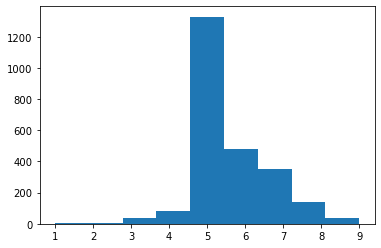

In [63]:
plt.hist(top_features['overallcond'], bins = 9)

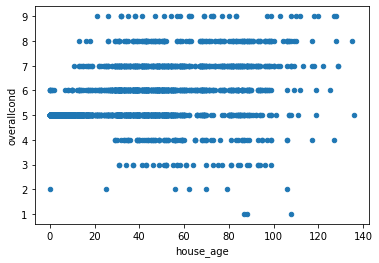

In [64]:
top_features[['house_age','overallcond']].plot(x='house_age',y='overallcond',kind='scatter')

It is interesting to find out that the overall condition of a house tend to be better in general as the house get older(positive correaltion). One reason could be there are relatively less number of houses in worse than avreage condition. The other possible explaination is when house inspectors rate the houses condition, they automatically take the 'age of house' into consideration, so the rating is given based on their knowledge about all the other houses in similar age in the area. 

In [65]:
age_cond = top_features.groupby(['neighborhood','house_age'])['overallcond'].mean().reset_index()

In [66]:
age_cond['house_age'] = age_cond['house_age'].astype(np.float)

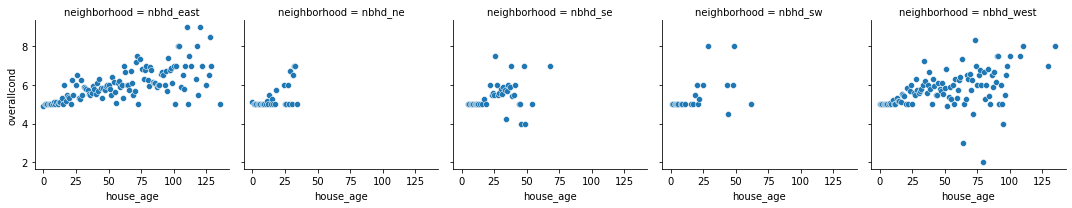

In [67]:
import seaborn as sns
# plt.figure(figsize=(12,10))
g = sns.FacetGrid(age_cond, col="neighborhood")
g.map(sns.scatterplot, 'house_age', 'overallcond')#, alpha=0.5)
# plt.legend(loc='right', bbox_to_anchor=(1.2, 0.8))

It seems when we separate the houses by neighborhood, the general pattern of rating doesn't change a lot, and it is even more apparent of the trend the condition rating goes up with house age. The interesting thing is, the ratings stay at average level until around age 15, and it start to increase.

(array([815., 233., 498., 413., 157., 210.,  83.,  36.,  10.]),
 array([  0.        ,  15.11111111,  30.22222222,  45.33333333,
         60.44444444,  75.55555556,  90.66666667, 105.77777778,
        120.88888889, 136.        ]),
 <a list of 9 Patch objects>)

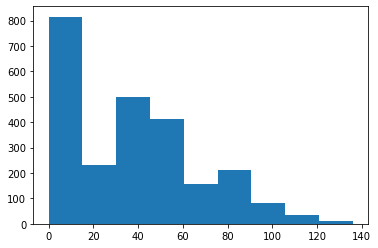

In [68]:
plt.hist(top_features['house_age'], bins = 9)

In [69]:
top_features['house_age'].describe()

count    2455.000000
mean       37.591446
std        29.493823
min         0.000000
25%         9.000000
50%        36.000000
75%        55.000000
max       136.000000
Name: house_age, dtype: float64

When checking number of house by age, it is clear that 30% houses included in our data set are youngger than 20 years old. And the median of house age is only 36. 

Except the house age alone, how people live inside the house treat it will affect the general condition of the house. In general, we assume people's level of caring follows a normal distribution. So it makes sense for the avreage condition of any group of house go back to average rating: 5. 

The reason for the older houses condition tend to go up, probably because the fact that our dataset only contains houses were eventually got sold. In this case, even if the house inspectors rate the house condition given the house age, it would still be harder for the older house to be sold.

#### Therefore, we would recommend the owners who having house age older than 15 should consider more about adaquate renovation, not only to increase the sale price, but to increase the chances of the house to be sold.

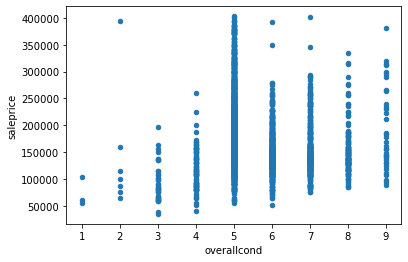

In [70]:
top_features[['saleprice','overallcond']].plot(x='overallcond',y='saleprice',kind='scatter')

In [71]:
cond_price = top_features[['saleprice','overallcond','house_age']]
cond_price['condition'] = pd.cut(cond_price['overallcond'],3,labels=['low','medium','high'])
cond_price.groupby('condition').agg({'saleprice':'mean','house_age':['mean','count']}).reset_index()

<ipython-input-71-169b2a826594>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cond_price['condition'] = pd.cut(cond_price['overallcond'],3,labels=['low','medium','high'])


condition      saleprice  house_age      
                      mean       mean count
0       low  100891.239130  64.586957    46
1    medium  180533.769353  30.168611  1886
2      high  156998.820268  61.984704   523

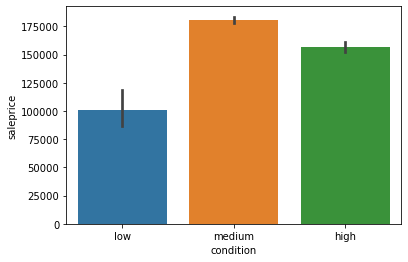

In [72]:
ax = sns.barplot(x="condition", y="saleprice", data=cond_price)

This also explains why overall condition is negatively related to house price. When we look at the mean saleprice of the low, medium and high overall rating houses, the group of high score is lower than the group of houses have medium score. That is because of these houses a lot of them are old house, and that drag down the average price.

## Newer House, Bigger House, and Better House

In [73]:
new = merged.copy()
new.loc[new['house_age']<=new['house_age'].quantile(0.2),'new'] = 'New'
new.loc[new['house_age']>new['house_age'].quantile(0.2),'new'] = 'Not New'

In [74]:
new.new.value_counts()

Not New    1927
New         528
Name: new, dtype: int64

In [75]:
new[['grlivarea','overallqual','overallcond','bbratio_abvgr','price_sqft','fireplaces',\
                   'totalbsmtsf','bsmtfinsf1','garagecars','heatingqc','saleprice']].mean()

grlivarea          1469.428921
overallqual           6.017515
overallcond           5.631365
bbratio_abvgr         1.467013
price_sqft          120.351114
fireplaces            0.595927
totalbsmtsf        1022.663544
bsmtfinsf1          429.628106
garagecars            1.736456
heatingqc             4.134420
saleprice        174027.726680
dtype: float64

In [76]:
new.groupby('new')[['grlivarea','overallqual','overallcond','bbratio_abvgr','price_sqft','fireplaces',\
                   'totalbsmtsf','bsmtfinsf1','garagecars','heatingqc','saleprice','poolarea']].mean().reset_index()

,new,grlivarea,overallqual,overallcond,bbratio_abvgr,price_sqft,fireplaces,totalbsmtsf,bsmtfinsf1,garagecars,heatingqc,saleprice,poolarea
0,New,1627.696970,7.306818,5.009470,1.057888,142.371853,0.647727,1244.844697,460.215909,2.272727,4.969697,229499.678030,0.000000
1,Not New,1426.063311,5.664245,5.801764,1.579113,114.317408,0.581733,961.785677,421.247016,1.589517,3.905553,158828.354437,2.150493


In [77]:
new.groupby('new')[['saleprice']].median().reset_index()

,new,saleprice
0,New,214500
1,Not New,146500


In [108]:
import plotly.figure_factory as ff

new_ = new.loc[new['new']=='New']['price_sqft']
old = new.loc[new['new']=='Not New']['price_sqft']

hist_data = [new_, old]
group_labels = ['New Home', 'Not New Home']
colors = ['rgb(0, 102, 153)','rgb(190, 190, 190)']

fig = ff.create_distplot(hist_data, group_labels, bin_size=10, colors= colors)
fig.update_layout(title_text=' ',
                  plot_bgcolor='rgb(256, 256, 256)')
fig.update_xaxes(title_text = " ") 
fig.update_yaxes(showgrid=True, gridwidth=0.5, gridcolor='rgb(230, 230, 230)')

fig.show()

In [109]:
import plotly.figure_factory as ff

new_ = new.loc[new['new']=='New']['overallqual']
old = new.loc[new['new']=='Not New']['overallqual']

hist_data = [new_, old]
group_labels = ['New Home', 'Not New Home']
colors = ['rgb(0, 102, 153)','rgb(190, 190, 190)'] 

fig = ff.create_distplot(hist_data, group_labels, bin_size=1, colors= colors)
fig.update_layout(title_text=' ',
                  plot_bgcolor='rgb(256, 256, 256)')
fig.update_xaxes(title_text = " ") 
fig.update_yaxes(showgrid=True, gridwidth=0.5, gridcolor='rgb(230, 230, 230)')

fig.show()

In [119]:
import plotly.express as px


fig = px.scatter(new, x="grlivarea", y="price_sqft", color='overallqual')
fig.update_layout(title_text=' ',
                  plot_bgcolor='rgb(256, 256, 256)')
fig.update_xaxes(title_text = " ") 
fig.update_yaxes(showgrid=True, gridwidth=0.5, gridcolor='rgb(230, 230, 230)')
fig.show()

In [79]:
large = merged.copy()
large.loc[large['grlivarea']>=large['grlivarea'].quantile(0.8),'size'] = 'Large'
large.loc[large['grlivarea']<large['grlivarea'].quantile(0.8),'size'] = 'Not Large'

In [80]:
large.groupby('size')[['house_age','overallqual','overallcond','bbratio_abvgr','price_sqft','fireplaces',\
                   'totalbsmtsf','bsmtfinsf1','garagecars','heatingqc','saleprice','poolarea']].mean().reset_index()

,size,house_age,overallqual,overallcond,bbratio_abvgr,price_sqft,fireplaces,totalbsmtsf,bsmtfinsf1,garagecars,heatingqc,saleprice,poolarea
0,Large,31.467480,6.922764,5.504065,1.355399,111.942170,1.014228,1180.359756,490.359756,2.205285,4.426829,241285.280488,5.186992
1,Not Large,39.126337,5.790627,5.663271,1.494987,122.458704,0.491085,983.139073,414.406521,1.618951,4.061131,157170.509934,0.811004


In [123]:
import plotly.figure_factory as ff

large_ = large.loc[large['size']=='Large']['price_sqft']
small = large.loc[large['size']=='Not Large']['price_sqft']

hist_data = [large_, small]
group_labels = ['Large Home', 'Not Large Home']
colors = ['rgb(0, 102, 153)','rgb(190, 190, 190)'] #'rgb(240, 188, 84)',

fig = ff.create_distplot(hist_data, group_labels, bin_size=10, colors= colors)
fig.update_layout(title_text=' ',
                  plot_bgcolor='rgb(256, 256, 256)')
fig.update_xaxes(title_text = " ") 
fig.update_yaxes(showgrid=True, gridwidth=0.5, gridcolor='rgb(230, 230, 230)')

fig.show()

In [111]:
import plotly.figure_factory as ff

large_ = large.loc[large['size']=='Large']['overallqual']
small = large.loc[large['size']=='Not Large']['overallqual']

hist_data = [large_, small]
group_labels = ['Large Home', 'Not Large Home']
colors = ['rgb(0, 102, 153)','rgb(190, 190, 190)'] #'rgb(240, 188, 84)',

fig = ff.create_distplot(hist_data, group_labels, bin_size=1, colors= colors)
fig.update_layout(title_text=' ',
                  plot_bgcolor='rgb(256, 256, 256)')
fig.update_xaxes(title_text = " ") 
fig.update_yaxes(showgrid=True, gridwidth=0.5, gridcolor='rgb(230, 230, 230)')

fig.show()

In [120]:
import plotly.express as px

fig = px.scatter(large, x="house_age", y="price_sqft", color="overallqual")
fig.update_layout(title_text=' ',
                  plot_bgcolor='rgb(256, 256, 256)')
fig.update_xaxes(title_text = " ") 
fig.update_yaxes(showgrid=True, gridwidth=0.5, gridcolor='rgb(230, 230, 230)')
fig.show()

In [83]:
highend = merged.copy()
highend.loc[(highend['house_age']<=highend['house_age'].quantile(0.2)) & \
            (highend['grlivarea']>=highend['grlivarea'].quantile(0.8)),'niche'] = 'Highend'
highend.loc[(highend['house_age']> highend['house_age'].quantile(0.2)) | \
            (highend['grlivarea']< highend['grlivarea'].quantile(0.8)),'niche'] = 'Not Highend'

In [112]:
import plotly.figure_factory as ff

high = highend.loc[highend['niche']=='Highend']['price_sqft']
other = highend.loc[highend['niche']=='Not Highend']['price_sqft']

hist_data = [high, other]
group_labels = ['Highend Home', 'Not Highend Home']
colors = ['rgb(0, 102, 153)','rgb(190, 190, 190)'] #'rgb(240, 188, 84)',

fig = ff.create_distplot(hist_data, group_labels, bin_size=10, colors= colors)
fig.update_layout(title_text=' ',
                  plot_bgcolor='rgb(256, 256, 256)')
fig.update_xaxes(title_text = " ") 
fig.update_yaxes(showgrid=True, gridwidth=0.5, gridcolor='rgb(230, 230, 230)')

fig.show()

In [113]:
import plotly.figure_factory as ff

high = highend.loc[highend['niche']=='Highend']['overallqual']
other = highend.loc[highend['niche']=='Not Highend']['overallqual']

hist_data = [high, other]
group_labels = ['Highend Home', 'Not Highend Home']
colors = ['rgb(0, 102, 153)','rgb(190, 190, 190)'] #'rgb(240, 188, 84)',

fig = ff.create_distplot(hist_data, group_labels, bin_size=1, colors= colors)
fig.update_layout(title_text=' ',
                  plot_bgcolor='rgb(256, 256, 256)')
fig.update_xaxes(title_text = " ") 
fig.update_yaxes(showgrid=True, gridwidth=0.5, gridcolor='rgb(230, 230, 230)')

fig.show()

In [86]:
new.groupby(['new','bsmtexposure'])['pid'].count().unstack().reset_index()

bsmtexposure,new,Av,Gd,Mn,No,No Bsmt
0,New,135,70,49,271,3
1,Not New,196,140,153,1376,62


In [87]:
new.groupby(['new','poolqc'])['pid'].count().unstack().reset_index()

poolqc,new,Ex,Fa,Gd,No Pool,TA
0,New,NaN,NaN,NaN,528.0,NaN
1,Not New,1.0,2.0,2.0,1919.0,3.0


In Ames, the newer houses(built after 2000) are in every aspects better than the older houses. They have larger living spaces, better quality material, on average every bedroom having a bathroom, and more parking spots. Also all the new houses don't have a swimming pool, while almost all new houses have a basement with 3 exceptions. In fact, having pool and not having basement will decrease the saleprice of the house in the model, that's probably why the constructors stopped to build those type of house after 2000. 


### Basement importance

Based on our research, basement is an important feature for houses in Ames, IA since tornados happen quite often in the city. During a tornado, families have to stay in the basement for safety consideration. Therefore, it is understanable such feature would have strong influence on the saleprice.